# This notebook calculates return levels and generates conditional exceedance probabilities and visualizes them
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib_scalebar.scalebar import ScaleBar  
from matplotlib.patches import FancyArrow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from shapely.geometry import box  
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import contextily as ctx
import folium
from folium.plugins import MarkerCluster,FeatureGroupSubGroup
from folium.plugins.treelayercontrol import TreeLayerControl
from folium.raster_layers import VideoOverlay
from folium.plugins import MarkerCluster
from shapely.geometry import Point
import re
import os
import glob
from tqdm import tqdm
import random
from branca.element import Template, MacroElement
from branca.element import Element
import datetime
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


In [2]:
import warnings
# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore")
# Suppress all UserWarnings, including PerformanceWarnings
warnings.simplefilter('ignore', category=UserWarning)
# font of the plots
plt.rcParams['font.family'] = 'Arial'

# plot the delineation accuracy

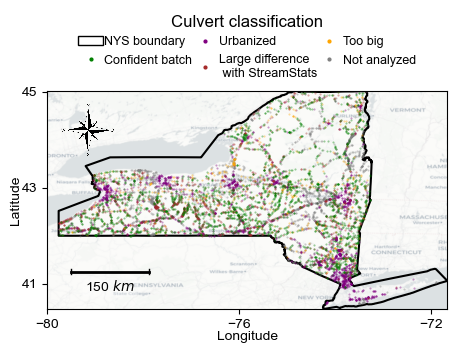

In [25]:
# Define CRS
crs_deg = 'EPSG:4326'
crs_m = 'EPSG:5070'

# Load files
base_dir = r'D:\culvert repo\data\initial layers'
culvert_shapefile = gpd.read_file(fr"{base_dir}\culvert_5070.shp")
state_shapefile = gpd.read_file(fr"{base_dir}\state_5070.shp")
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc_All.xlsx'
merged_culvert = pd.read_excel(excel_output_file)

# Reproject shapefiles
culvert_shapefile = culvert_shapefile.to_crs(crs_deg)
state_shapefile = state_shapefile.to_crs(crs_deg)

# Prepare analyzed and accurate bins
analyzed = merged_culvert[merged_culvert['Area_80'].notna()]
accurate_bins = analyzed.loc[analyzed['delineation_accuracy'] == 1, 'BIN']

# Build BIN to reason map
reason_map = {}
for _, row in analyzed.iterrows():
    if row['delineation_accuracy'] == 1:
        reason_map[row['BIN']] = 'accurate'
    else:
        if row['not_urbanized'] is False:
            reason_map[row['BIN']] = 'urbanized'
        elif row['diff_area'] > 0.25:
            reason_map[row['BIN']] = 'large_diff'
        elif row['Area'] > 1e7:
            reason_map[row['BIN']] = 'too_big'

# Assign category to each culvert
def classify(bin_val):
    if bin_val not in reason_map:
        return 'not_analyzed'
    return reason_map[bin_val]

culvert_shapefile['reason'] = culvert_shapefile['BIN'].apply(classify)

# Color map (unchanged categories; aesthetics focus is placement/size/legend/basemap)
color_dict = {
    'not_analyzed': 'gray',
    'urbanized': 'purple',
    'large_diff': 'brown',
    'too_big': 'orange',
    'accurate': 'green'
}
culvert_shapefile['color'] = culvert_shapefile['reason'].map(color_dict)

# --- FIGURE SIZE & AXIS STYLING (Aesthetics) ---
fig_width, fig_height = (4.5*1.25, 2.75*1.25)  # << CHANGED: fixed size per style guide
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
minx, miny, maxx, maxy = state_shapefile.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel('Longitude', fontsize=10, labelpad=0)  # << CHANGED
ax.set_ylabel('Latitude', fontsize=10, labelpad=0)   # << CHANGED
ax.tick_params(axis='both', which='major', labelsize=10)  # << CHANGED
ax.set_xticks([-80, -76, -72])   # << CHANGED: manual ticks
ax.set_yticks([41, 43, 45])      # << CHANGED: manual ticks

# State boundary
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')  # << CHANGED: emphasize outline only

# Plot culverts by reason (apply tiny semi-transparent points)
for reason, color in color_dict.items():
    subset = culvert_shapefile[culvert_shapefile['reason'] == reason]
    if subset.empty:
        continue
    subset.plot(ax=ax, color=color, markersize=0.25, alpha=0.4, marker='o', linestyle='None')  # << CHANGED

# Basemap (CartoDB Positron with hidden attribution)
ctx.add_basemap(ax, crs=crs_deg, source=ctx.providers.CartoDB.Positron, alpha=0.8)  # << CHANGED
if ax.texts:  # hide attribution if present  # << CHANGED
    ax.texts[-1].set_visible(False)

# --- CUSTOM 150-km SCALE BAR (Aesthetics) ---
# Compute meters-per-degree from bbox width in EPSG:5070
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=crs_deg)
bbox_5070 = bbox_gdf.to_crs(crs_m)
scale_width_m = bbox_5070.geometry[0].bounds[2] - bbox_5070.geometry[0].bounds[0]
scale_width_deg = maxx - minx
meters_per_degree = scale_width_m / scale_width_deg

bar_length_km = 150  # << CHANGED: fixed length
deg_per_km = 1 / (meters_per_degree / 1000)
bar_length_deg = bar_length_km * deg_per_km

# Fixed anchor (do NOT modify these values per style)
bar_x_start = -79.5
bar_x_end = bar_x_start + bar_length_deg
bar_y = 41.25

# Draw scale bar
ax.plot([bar_x_start, bar_x_end], [bar_y, bar_y], color='black', lw=2)
ax.plot([bar_x_start, bar_x_start], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)
ax.plot([bar_x_end, bar_x_end], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)
ax.text((bar_x_start + bar_x_end) / 2, bar_y - 0.15, f'{bar_length_km} $km$',
        ha='center', va='top', fontsize=10, family='Arial',
        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.2'))  # << CHANGED

# --- NORTH ARROW (Aesthetics) ---
img_path = r'D:\culvert repo\Results\north_arrow\N_arrow.png'
north_img = mpimg.imread(img_path)
imagebox = OffsetImage(north_img, zoom=0.06)  # << CHANGED: fixed zoom
ab = AnnotationBbox(imagebox, (0.1, 0.82), xycoords='axes fraction', frameon=False)  # << CHANGED: fixed anchor
ax.add_artist(ab)

# Legend (above figure, no frame, compact)
legend_items = [
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=1, label='NYS boundary'),
    Line2D([0], [0], marker='o', color='green', markersize=.2, linestyle='None', label='Confident batch'),
    Line2D([0], [0], marker='o', color='purple', markersize=.2, linestyle='None', label='Urbanized'),
    Line2D([0], [0], marker='o', color='brown', markersize=.2, linestyle='None', label='Large difference \n with StreamStats'),
    Line2D([0], [0], marker='o', color='orange', markersize=.2, linestyle='None', label='Too big'),
    Line2D([0], [0], marker='o', color='gray', markersize=.2, linestyle='None', label='Not analyzed')
]
plt.legend(
    handles=legend_items,
    title="Culvert classification",  
    fontsize=9,
    title_fontsize=12,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.4),
    frameon=False,             
    ncol=3,
    handletextpad=0.1,
    columnspacing=0,
    markerscale=10
)

# Save and show
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_reason_based_classification_paper.png',
            dpi=300, bbox_inches='tight')  # << CHANGED: tight bbox
plt.show()


In [42]:
culvert_shapefile=culvert_shapefile.drop_duplicates(subset=['BIN'], keep='first')
np.shape(culvert_shapefile)

(8062, 46)

In [43]:
print(culvert_shapefile['reason'].value_counts())

reason
accurate        2418
urbanized       2096
not_analyzed    1597
large_diff      1526
too_big          425
Name: count, dtype: int64


In [44]:
culvert_shapefile[['BIN','reason']]

,BIN,reason
0,C010001,urbanized
1,C010003,not_analyzed
2,C010004,urbanized
3,C010008,urbanized
5,C010009,urbanized
...,...,...
8556,CN50005,urbanized
8557,CN50006,urbanized
8558,CN50007,urbanized
8559,CN50008,urbanized


In [45]:
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq.xlsx'
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_UL_LL.xlsx'
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_wet_dry.xlsx'
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100.xlsx'
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100.xlsx'
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rainandQ.xlsx'
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_2030_2100_future_rain_LU_Q.xlsx'
excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_hydrq_hydoq_UL_LL_All_V2.xlsx'

merged_culvert=pd.read_excel(excel_output_file)

In [31]:
merged_culvert__all = culvert_shapefile[['BIN','reason']].merge(merged_culvert, how='left', on='BIN') # to have compelete list for the culverts

merged_culvert = merged_culvert.merge(culvert_shapefile[['BIN','reason']], how='left', on='BIN')


In [13]:
merged_culvert__all.reason.value_counts()

reason
accurate        2418
urbanized       2096
not_analyzed    1597
large_diff      1526
too_big          425
Name: count, dtype: int64

In [358]:
8062-1597

6465

In [ ]:
merged_culvert

In [15]:
np.shape(merged_culvert__all)

(8062, 475)

# Capacity to load ratio

In [36]:
%%time
# calculates return periods up t0 1000-years
# calculate the return periods and their class
def assign_return_period(row):
    if row['Q'] < row['Q_2']:
        return pd.Series([2, '0-2'])
    elif row['Q'] < row['Q_5']:
        return pd.Series([5, '2-5'])
    elif row['Q'] < row['Q_10']:
        return pd.Series([10, '5-10'])
    elif row['Q'] < row['Q_25']:
        return pd.Series([25, '10-25'])
    elif row['Q'] < row['Q_50']:
        return pd.Series([50, '25-50'])
    elif row['Q'] < row['Q_100']:
        return pd.Series([100, '50-100'])
    elif row['Q'] < row['Q_200']:
        return pd.Series([200, '100-200'])
    elif row['Q'] < row['Q_500']:
        return pd.Series([500, '200-500'])
    elif row['Q'] < row['Q_1000']:
        return pd.Series([1000, '500-1000'])
    else:
        return pd.Series([2000, '1000-$∞$'])

def assign_return_period_c(row):
    if row['average_Q_maxhw'] < row['Q_2']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row['Q_5']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row['Q_10']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row['Q_25']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row['Q_50']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row['Q_100']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row['Q_200']:
        return pd.Series([200, '100-200'])
    elif row['average_Q_maxhw'] < row['Q_500']:
        return pd.Series([500, '200-500'])
    elif row['average_Q_maxhw'] < row['Q_1000']:
        return pd.Series([1000, '500-1000'])
    else:
        return pd.Series([2000, '1000-$∞$'])
        
def assign_return_period_c_LL(row):
    if row['average_Q_maxhw'] < row['Q_LL_2']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row['Q_LL_5']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row['Q_LL_10']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row['Q_LL_25']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row['Q_LL_50']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row['Q_LL_100']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row['Q_LL_200']:
        return pd.Series([200, '100-200'])
    elif row['average_Q_maxhw'] < row['Q_LL_500']:
        return pd.Series([500, '200-500'])
    elif row['average_Q_maxhw'] < row['Q_LL_1000']:
        return pd.Series([1000, '500-1000'])
    else:
        return pd.Series([2000, '1000-$∞$'])

def assign_return_period_c_UL(row):
    if row['average_Q_maxhw'] < row['Q_UL_2']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row['Q_UL_5']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row['Q_UL_10']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row['Q_UL_25']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row['Q_UL_50']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row['Q_UL_100']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row['Q_UL_200']:
        return pd.Series([200, '100-200'])
    elif row['average_Q_maxhw'] < row['Q_UL_500']:
        return pd.Series([500, '200-500'])
    elif row['average_Q_maxhw'] < row['Q_UL_1000']:
        return pd.Series([1000, '500-1000'])
    else:
        return pd.Series([2000, '1000-$∞$'])
        
def assign_return_period_c_condition(row, condition):
    q_val = row['average_Q_maxhw']
    # Build the appropriate Q column names dynamically
    if q_val < row[f'Q_2_{condition}']:
        return pd.Series([2, '0-2'])
    elif q_val < row[f'Q_5_{condition}']:
        return pd.Series([5, '2-5'])
    elif q_val < row[f'Q_10_{condition}']:
        return pd.Series([10, '5-10'])
    elif q_val < row[f'Q_25_{condition}']:
        return pd.Series([25, '10-25'])
    elif q_val < row[f'Q_50_{condition}']:
        return pd.Series([50, '25-50'])
    elif q_val < row[f'Q_100_{condition}']:
        return pd.Series([100, '50-100'])
    elif q_val < row[f'Q_200_{condition}']:
        return pd.Series([200, '100-200'])
    elif q_val < row[f'Q_500_{condition}']:
        return pd.Series([500, '200-500'])
    elif q_val < row[f'Q_1000_{condition}']:
        return pd.Series([1000, '500-1000'])
    else:
        return pd.Series([2000, '1000-$∞$'])
        
def assign_return_period_c_future_LU (row, year, secnario):
    q_val = row['average_Q_maxhw']
    if row['average_Q_maxhw'] < row[f'Q_2_{year}_{secnario}_Wet']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row[f'Q_5_{year}_{secnario}_Wet']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row[f'Q_10_{year}_{secnario}_Wet']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row[f'Q_25_{year}_{secnario}_Wet']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row[f'Q_50_{year}_{secnario}_Wet']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row[f'Q_100_{year}_{secnario}_Wet']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row[f'Q_200_{year}_{secnario}_Wet']:
        return pd.Series([200, '100-200'])
    elif row['average_Q_maxhw'] < row[f'Q_500_{year}_{secnario}_Wet']:
        return pd.Series([500, '200-500'])
    elif row['average_Q_maxhw'] < row[f'Q_1000_{year}_{secnario}_Wet']:
        return pd.Series([1000, '500-1000'])
    else:
        return pd.Series([2000, '1000-$∞$'])  

def assign_return_period_c_future_rain (row, year, secnario):
    q_val = row['average_Q_maxhw']
    if row['average_Q_maxhw'] < row[f'Q_2_{time}_{scenario}']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row[f'Q_5_{time}_{scenario}']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row[f'Q_10_{time}_{scenario}']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row[f'Q_25_{time}_{scenario}']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row[f'Q_50_{time}_{scenario}']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row[f'Q_100_{time}_{scenario}']:
        return pd.Series([100, '50-100'])
    else:
        return pd.Series([200, '100-$∞$']) 


def assign_return_period_c_future_rain_LL(row, year, scenario):
    # Convert A2/B2 to rcp85/rcp45
    rcp = 'rcp85' if scenario == 'A2' else 'rcp45'
    q_val = row['average_Q_maxhw']
    
    if q_val < row[f'Q_2_{year}_{scenario}_Wet_fr']:
        return pd.Series([2, '0-2'])
    elif q_val < row[f'Q_5_{year}_{scenario}_Wet_fr']:
        return pd.Series([5, '2-5'])
    elif q_val < row[f'Q_10_{year}_{scenario}_Wet_fr']:
        return pd.Series([10, '5-10'])
    elif q_val < row[f'Q_25_{year}_{scenario}_Wet_fr']:
        return pd.Series([25, '10-25'])
    elif q_val < row[f'Q_50_{year}_{scenario}_Wet_fr']:
        return pd.Series([50, '25-50'])
    elif q_val < row[f'Q_100_{year}_{scenario}_Wet_fr']:
        return pd.Series([100, '50-100'])
    else:
        return pd.Series([200, '100-$∞$'])  
               
# Apply the function
merged_culvert[['RP', 'RP_class']] = merged_culvert.apply(assign_return_period, axis=1)
merged_culvert[['RP_c', 'RP_class_c']] = merged_culvert.apply(assign_return_period_c, axis=1)
merged_culvert[['RP_c_LL', 'RP_class_c_LL']] = merged_culvert.apply(assign_return_period_c_UL, axis=1)
merged_culvert[['RP_c_UL', 'RP_class_c_UL']] = merged_culvert.apply(assign_return_period_c_LL, axis=1)
merged_culvert[['RP_c_dry', 'RP_class_c_dry']] = merged_culvert.apply(lambda row: assign_return_period_c_condition(row, 'dry'), axis=1)
merged_culvert[['RP_c_nor', 'RP_class_c_nor']] = merged_culvert.apply(lambda row: assign_return_period_c_condition(row, 'nor'), axis=1)
# 
for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
    for secnario in ['A1B', 'A2', 'B1', 'B2']:
        merged_culvert[[f'RP_c_{year}_{secnario}', f'RP_class_c_{year}_{secnario}']] = \
            merged_culvert.apply(lambda row: assign_return_period_c_future_LU (row, year, secnario), axis=1)
#
for time in ['2010-2039','2040-2069','2070-2099']:
    for scenario in ['rcp45','rcp85']:
        merged_culvert[[f'RP_c_{time}_{scenario}', f'RP_class_c_{time}_{scenario}']] = \
            merged_culvert.apply(lambda row: assign_return_period_c_future_rain (row, time, secnario), axis=1)
#
for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
    for secnario in ['A2', 'B2']:
        merged_culvert[[f'RP_c_{year}_{secnario}_lr', f'RP_class_c_{year}_{secnario}_lr']] = \
            merged_culvert.apply(lambda row: assign_return_period_c_future_rain_LL (row, year, secnario), axis=1)

CPU times: total: 13.3 s
Wall time: 13.7 s


In [ ]:
%%time
# calculates return periods up t0 100-years
# calculate the return periods and their class
def assign_return_period(row):
    if row['Q'] < row['Q_2']:
        return pd.Series([2, '0-2'])
    elif row['Q'] < row['Q_5']:
        return pd.Series([5, '2-5'])
    elif row['Q'] < row['Q_10']:
        return pd.Series([10, '5-10'])
    elif row['Q'] < row['Q_25']:
        return pd.Series([25, '10-25'])
    elif row['Q'] < row['Q_50']:
        return pd.Series([50, '25-50'])
    elif row['Q'] < row['Q_100']:
        return pd.Series([100, '50-100'])
    elif row['Q'] < row['Q_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])

def assign_return_period_c(row):
    if row['average_Q_maxhw'] < row['Q_2']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row['Q_5']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row['Q_10']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row['Q_25']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row['Q_50']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row['Q_100']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row['Q_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])
        
def assign_return_period_c_LL(row):
    if row['average_Q_maxhw'] < row['Q_LL_2']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row['Q_LL_5']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row['Q_LL_10']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row['Q_LL_25']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row['Q_LL_50']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row['Q_LL_100']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row['Q_LL_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_LL_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_LL_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])

def assign_return_period_c_UL(row):
    if row['average_Q_maxhw'] < row['Q_UL_2']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row['Q_UL_5']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row['Q_UL_10']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row['Q_UL_25']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row['Q_UL_50']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row['Q_UL_100']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row['Q_UL_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_UL_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_UL_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])
        
def assign_return_period_c_condition(row, condition):
    q_val = row['average_Q_maxhw']
    # Build the appropriate Q column names dynamically
    if q_val < row[f'Q_2_{condition}']:
        return pd.Series([2, '0-2'])
    elif q_val < row[f'Q_5_{condition}']:
        return pd.Series([5, '2-5'])
    elif q_val < row[f'Q_10_{condition}']:
        return pd.Series([10, '5-10'])
    elif q_val < row[f'Q_25_{condition}']:
        return pd.Series([25, '10-25'])
    elif q_val < row[f'Q_50_{condition}']:
        return pd.Series([50, '25-50'])
    elif q_val < row[f'Q_100_{condition}']:
        return pd.Series([100, '50-100'])
    elif q_val < row[f'Q_200_{condition}']:
        return pd.Series([200, '100-$∞$'])
    elif q_val < row[f'Q_500_{condition}']:
        return pd.Series([200, '100-$∞$'])
    elif q_val < row[f'Q_1000_{condition}']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])
        
def assign_return_period_c_future_LU (row, year, secnario):
    q_val = row['average_Q_maxhw']
    if row['average_Q_maxhw'] < row[f'Q_2_{year}_{secnario}_Wet']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row[f'Q_5_{year}_{secnario}_Wet']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row[f'Q_10_{year}_{secnario}_Wet']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row[f'Q_25_{year}_{secnario}_Wet']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row[f'Q_50_{year}_{secnario}_Wet']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row[f'Q_100_{year}_{secnario}_Wet']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row[f'Q_200_{year}_{secnario}_Wet']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row[f'Q_500_{year}_{secnario}_Wet']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row[f'Q_1000_{year}_{secnario}_Wet']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])  

def assign_return_period_c_future_rain (row, year, secnario):
    q_val = row['average_Q_maxhw']
    if row['average_Q_maxhw'] < row[f'Q_2_{time}_{scenario}']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row[f'Q_5_{time}_{scenario}']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row[f'Q_10_{time}_{scenario}']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row[f'Q_25_{time}_{scenario}']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row[f'Q_50_{time}_{scenario}']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row[f'Q_100_{time}_{scenario}']:
        return pd.Series([100, '50-100'])
    else:
        return pd.Series([200, '100-$∞$']) 


def assign_return_period_c_future_rain_LL(row, year, scenario):
    # Convert A2/B2 to rcp85/rcp45
    rcp = 'rcp85' if scenario == 'A2' else 'rcp45'
    q_val = row['average_Q_maxhw']
    
    if q_val < row[f'Q_2_{year}_{scenario}_Wet_fr']:
        return pd.Series([2, '0-2'])
    elif q_val < row[f'Q_5_{year}_{scenario}_Wet_fr']:
        return pd.Series([5, '2-5'])
    elif q_val < row[f'Q_10_{year}_{scenario}_Wet_fr']:
        return pd.Series([10, '5-10'])
    elif q_val < row[f'Q_25_{year}_{scenario}_Wet_fr']:
        return pd.Series([25, '10-25'])
    elif q_val < row[f'Q_50_{year}_{scenario}_Wet_fr']:
        return pd.Series([50, '25-50'])
    elif q_val < row[f'Q_100_{year}_{scenario}_Wet_fr']:
        return pd.Series([100, '50-100'])
    else:
        return pd.Series([200, '100-$∞$'])  
               
# Apply the function
merged_culvert[['RP', 'RP_class']] = merged_culvert.apply(assign_return_period, axis=1)
merged_culvert[['RP_c', 'RP_class_c']] = merged_culvert.apply(assign_return_period_c, axis=1)
merged_culvert[['RP_c_LL', 'RP_class_c_LL']] = merged_culvert.apply(assign_return_period_c_UL, axis=1)
merged_culvert[['RP_c_UL', 'RP_class_c_UL']] = merged_culvert.apply(assign_return_period_c_LL, axis=1)
merged_culvert[['RP_c_dry', 'RP_class_c_dry']] = merged_culvert.apply(lambda row: assign_return_period_c_condition(row, 'dry'), axis=1)
merged_culvert[['RP_c_nor', 'RP_class_c_nor']] = merged_culvert.apply(lambda row: assign_return_period_c_condition(row, 'nor'), axis=1)
# 
for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
    for secnario in ['A1B', 'A2', 'B1', 'B2']:
        merged_culvert[[f'RP_c_{year}_{secnario}', f'RP_class_c_{year}_{secnario}']] = \
            merged_culvert.apply(lambda row: assign_return_period_c_future_LU (row, year, secnario), axis=1)
#
for time in ['2010-2039','2040-2069','2070-2099']:
    for scenario in ['rcp45','rcp85']:
        merged_culvert[[f'RP_c_{time}_{scenario}', f'RP_class_c_{time}_{scenario}']] = \
            merged_culvert.apply(lambda row: assign_return_period_c_future_rain (row, time, secnario), axis=1)
#
for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
    for secnario in ['A2', 'B2']:
        merged_culvert[[f'RP_c_{year}_{secnario}_lr', f'RP_class_c_{year}_{secnario}_lr']] = \
            merged_culvert.apply(lambda row: assign_return_period_c_future_rain_LL (row, year, secnario), axis=1)

In [46]:
%%time
# calculates return periods up t0 100-years
# calculate the return periods and their class
def  assign_return_period_c(row):
    if row['Q'] < row['Q_2']:
        return pd.Series([2, '0-2'])
    elif row['Q'] < row['Q_5']:
        return pd.Series([5, '2-5'])
    elif row['Q'] < row['Q_10']:
        return pd.Series([10, '5-10'])
    elif row['Q'] < row['Q_25']:
        return pd.Series([25, '10-25'])
    elif row['Q'] < row['Q_50']:
        return pd.Series([50, '25-50'])
    elif row['Q'] < row['Q_100']:
        return pd.Series([100, '50-100'])
    elif row['Q'] < row['Q_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])

def assign_return_period(row):
    if row['average_Q_maxhw'] < row['Q_2']:
        return pd.Series([2, '0-2'])
    elif row['average_Q_maxhw'] < row['Q_5']:
        return pd.Series([5, '2-5'])
    elif row['average_Q_maxhw'] < row['Q_10']:
        return pd.Series([10, '5-10'])
    elif row['average_Q_maxhw'] < row['Q_25']:
        return pd.Series([25, '10-25'])
    elif row['average_Q_maxhw'] < row['Q_50']:
        return pd.Series([50, '25-50'])
    elif row['average_Q_maxhw'] < row['Q_100']:
        return pd.Series([100, '50-100'])
    elif row['average_Q_maxhw'] < row['Q_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['average_Q_maxhw'] < row['Q_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])
        
def assign_return_period_c_LL(row):
    if row['Q'] < row['Q_LL_2']:
        return pd.Series([2, '0-2'])
    elif row['Q'] < row['Q_LL_5']:
        return pd.Series([5, '2-5'])
    elif row['Q'] < row['Q_LL_10']:
        return pd.Series([10, '5-10'])
    elif row['Q'] < row['Q_LL_25']:
        return pd.Series([25, '10-25'])
    elif row['Q'] < row['Q_LL_50']:
        return pd.Series([50, '25-50'])
    elif row['Q'] < row['Q_LL_100']:
        return pd.Series([100, '50-100'])
    elif row['Q'] < row['Q_LL_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_LL_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_LL_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])

def assign_return_period_c_UL(row):
    if row['Q'] < row['Q_UL_2']:
        return pd.Series([2, '0-2'])
    elif row['Q'] < row['Q_UL_5']:
        return pd.Series([5, '2-5'])
    elif row['Q'] < row['Q_UL_10']:
        return pd.Series([10, '5-10'])
    elif row['Q'] < row['Q_UL_25']:
        return pd.Series([25, '10-25'])
    elif row['Q'] < row['Q_UL_50']:
        return pd.Series([50, '25-50'])
    elif row['Q'] < row['Q_UL_100']:
        return pd.Series([100, '50-100'])
    elif row['Q'] < row['Q_UL_200']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_UL_500']:
        return pd.Series([200, '100-$∞$'])
    elif row['Q'] < row['Q_UL_1000']:
        return pd.Series([200, '100-$∞$'])
    else:
        return pd.Series([200, '100-$∞$'])
        

# Apply the function
merged_culvert[['RP', 'RP_class']] = merged_culvert.apply(assign_return_period, axis=1)
merged_culvert[['RP_c', 'RP_class_c']] = merged_culvert.apply(assign_return_period_c, axis=1)
merged_culvert[['RP_c_LL', 'RP_class_c_LL']] = merged_culvert.apply(assign_return_period_c_UL, axis=1)
merged_culvert[['RP_c_UL', 'RP_class_c_UL']] = merged_culvert.apply(assign_return_period_c_LL, axis=1)

CPU times: total: 2.3 s
Wall time: 2.36 s


### Save the results as an Excel file

In [47]:
merged_culvert__all = culvert_shapefile[['BIN','reason']].merge(merged_culvert, how='left', on='BIN') # to have compelete list for the culverts


In [48]:
np.shape(merged_culvert__all)

(8062, 483)

In [ ]:
merged_culvert__all

In [67]:
out_culvert=merged_culvert__all
print(list(out_culvert.columns))
out_culvert=out_culvert[['BIN','Area','reason','LFP_len','Bas_S','t_c','CN_wet','S','Ia','Q','average_Q_maxhw','Q_LL_2','Q_2','Q_UL_2',\
                         'Q_LL_5','Q_5','Q_UL_5','Q_LL_10','Q_10','Q_UL_10','Q_LL_25','Q_25','Q_UL_25','Q_LL_50','Q_50','Q_UL_50',\
                         'Q_LL_100','Q_100','Q_UL_100','Q_LL_200','Q_200','Q_UL_200','Q_LL_500','Q_500','Q_UL_500',\
                         'Q_LL_1000','Q_1000','Q_UL_1000','RP_class','RP_class_c','RP_class_c_LL','RP_class_c_UL']]


['BIN', 'reason', 'Ini_lon', 'Ini_lat', 'lonsnap_10', 'latsnap_10', 'Area_10', 'Peri_10', 'LFP_len_10', 'LFP_S_10', 'Bas_S_10', 'cul_S10', 'lonsnap_20', 'latsnap_20', 'Area_20', 'Peri_20', 'LFP_len_20', 'LFP_S_20', 'Bas_S_20', 'cul_S20', 'lonsnap_40', 'latsnap_40', 'Area_40', 'Peri_40', 'LFP_len_40', 'LFP_S_40', 'Bas_S_40', 'cul_S40', 'lonsnap_80', 'latsnap_80', 'Area_80', 'Peri_80', 'LFP_len_80', 'LFP_S_80', 'Bas_S_80', 'cul_S80', 'geometry_x', 'OBJECTID_1', 'FID_', 'REGION_x', 'COUNTY_x', 'GTMS___MAT', 'GTMS___TYP', 'CARRIED', 'CROSSED', 'LATITUDE__', 'LATITUDE_1', 'LONGITUDE', 'LONGITUD_1', 'YEAR_BUILT', 'NUMBER_OF', 'NUMBER_O_1', 'MAXIMUM_SP', 'BRIDGE_LEN', 'OUT_TO_OUT', 'DECK_AREA', 'BA_WINGWAL', 'EA_WINGWAL', 'BA_SKEW_AN', 'EA_SKEW_AN', 'DEPTH_OF_C', 'BARREL_LEN', 'FUNCTIONAL', 'DETOUR_LEN', 'STREAM_BED', 'BANK_PROTE', 'VELOCITY_O', 'FEATURES_A', 'GENERAL_RE', 'SCOUR_CRIT', 'MATERIAL', 'DESIGN_TYP', 'ORIGINAL_C', 'LATITUDE', 'LONGITUD_2', 'NEAR_FID', 'NEAR_DIST', 'NEAR_X', 'NEAR_

In [68]:
# add streamstats area
#load the drain area of the streamstats
file_path=r"D:\culvert repo\Results\Streamstats results\all_merged_culverts_watersheds.shp"
streamstats_watersheds = gpd.read_file(file_path)
streamstats=streamstats_watersheds.drop_duplicates(subset=['BIN'],keep='first')
streamstats.reset_index(drop=True, inplace=True)
streamstats.head()

,OBJECTID_1,FID_,BIN,REGION,COUNTY,GTMS___MAT,GTMS___TYP,CARRIED,CROSSED,LATITUDE__,...,SSURGOA,OUTLETY,DRNAREA,RELATEDOID,WarningM_1,HUCID_y,Edited,Shape_Leng,Shape_Area,geometry
0,1,0,C010001,0,1,1,19,25A 25A 03021009,W/O LAKEVILLE RD.,40,...,0.0,4515155.0,0.5500,None,"Warning! Long Island, Staten Island and surrou...",02030200,0,7860.0,1424000.0,"POLYGON ((-73.70865 40.76526, -73.70889 40.765..."
1,3,2,C010004,0,1,1,19,25A 25A 0302 1116,DRAINAGE DITCH,40,...,0.0,4522205.0,1.2900,None,"Warning! Long Island, Staten Island and surrou...",02030200,0,12060.0,3345500.0,"MULTIPOLYGON (((-73.55229 40.83484, -73.55229 ..."
2,4,3,C010008,0,1,1,19,PRIVATE DRIVE @ RTE 900-RM 1019,UNKNOWN STREAM,40,...,0.0,4521925.0,8.0900,None,"Warning! Long Island, Staten Island and surrou...",02030200,0,29680.0,20955100.0,"POLYGON ((-73.62352 40.79715, -73.62482 40.797..."
3,6,5,C010009,0,1,1,19,THE GLEN,Unnamed Creek,40,...,0.0,4522415.0,0.0509,None,"Warning! Long Island, Staten Island and surrou...",02030200,0,2180.0,131700.0,"POLYGON ((-73.60956 40.8414, -73.60979 40.8414..."
4,7,6,C010010,0,1,1,19,107 107 03012004,Unnamed Creek,40,...,0.0,4523715.0,9.6400,None,"Warning! Long Island, Staten Island and surrou...",02030200,0,35740.0,24954000.0,"MULTIPOLYGON (((-73.63201 40.83986, -73.63213 ..."


In [69]:
streamstats['DRNAREA']=streamstats['DRNAREA']*2.59

### Add other features of the culvert dataset to the final excel file

In [ ]:
out_culvert = out_culvert.merge(streamstats[['BIN','DRNAREA']], on='BIN', how='left')
out_culvert=out_culvert[['BIN','Area','DRNAREA','reason','LFP_len','Bas_S','t_c','CN_wet','S','Ia','Q','average_Q_maxhw','Q_LL_2','Q_2','Q_UL_2',\
                         'Q_LL_5','Q_5','Q_UL_5','Q_LL_10','Q_10','Q_UL_10','Q_LL_25','Q_25','Q_UL_25','Q_LL_50','Q_50','Q_UL_50',\
                         'Q_LL_100','Q_100','Q_UL_100','Q_LL_200','Q_200','Q_UL_200','Q_LL_500','Q_500','Q_UL_500',\
                         'Q_LL_1000','Q_1000','Q_UL_1000','RP_class','RP_class_c','RP_class_c_LL','RP_class_c_UL']]
culvert_1=pd.read_excel(r'D:\culvert repo\Results\Hydraulic analysis\hydraulic_analysis.xlsx')
culvert_2=culvert_1.iloc[:,1:41]
out_culvert = out_culvert.merge(culvert_2, how='left', on='BIN')
out_culvert


In [ ]:
out_culvert.Area=(out_culvert.Area/1e6).round(5)
out_culvert.DRNAREA=(out_culvert.DRNAREA).round(5)
out_culvert.LFP_len=(out_culvert.LFP_len/1e3).round(2)
out_culvert.Bas_S=(out_culvert.Bas_S).round(2)
out_culvert.t_c=(out_culvert.t_c).round(1)
out_culvert.CN_wet=(out_culvert.CN_wet).round(1)
out_culvert.S=(out_culvert.S).round(1)
out_culvert.Q=(out_culvert.Q).round(1)
out_culvert.average_Q_maxhw=(out_culvert.average_Q_maxhw).round(1)
out_culvert.Q_LL_2=(out_culvert.Q_LL_2).round(1)
out_culvert.Q_2=(out_culvert.Q_2).round(1)
out_culvert.Q_UL_2=(out_culvert.Q_UL_2).round(1)
out_culvert.Q_LL_5=(out_culvert.Q_LL_5).round(1)
out_culvert.Q_5=(out_culvert.Q_5).round(1)
out_culvert.Q_UL_5=(out_culvert.Q_UL_5).round(1)
out_culvert.Q_LL_10=(out_culvert.Q_LL_10).round(1)
out_culvert.Q_10=(out_culvert.Q_10).round(1)
out_culvert.Q_UL_10=(out_culvert.Q_UL_10).round(1)
out_culvert.Q_LL_25=(out_culvert.Q_LL_25).round(1)
out_culvert.Q_25=(out_culvert.Q_25).round(1)
out_culvert.Q_UL_25=(out_culvert.Q_UL_25).round(1)
out_culvert.Q_LL_50=(out_culvert.Q_LL_50).round(1)
out_culvert.Q_50=(out_culvert.Q_50).round(1)
out_culvert.Q_UL_50=(out_culvert.Q_UL_50).round(1)
out_culvert.Q_LL_100=(out_culvert.Q_LL_100).round(1)
out_culvert.Q_100=(out_culvert.Q_100).round(1)
out_culvert.Q_UL_100=(out_culvert.Q_UL_100).round(1)
out_culvert.Q_LL_200=(out_culvert.Q_LL_200).round(1)
out_culvert.Q_200=(out_culvert.Q_200).round(1)
out_culvert.Q_UL_200=(out_culvert.Q_UL_200).round(1)
out_culvert.Q_LL_500=(out_culvert.Q_LL_500).round(1)
out_culvert.Q_500=(out_culvert.Q_500).round(1)
out_culvert.Q_UL_500=(out_culvert.Q_UL_500).round(1)
out_culvert.Q_LL_1000=(out_culvert.Q_LL_1000).round(1)
out_culvert.Q_1000=(out_culvert.Q_1000).round(1)
out_culvert.Q_UL_1000=(out_culvert.Q_UL_1000).round(1)
out_culvert.head()

In [72]:
outculvert=out_culvert.rename(columns={ 'Area': 'Drainage area (km2)',
                                        'DRNAREA': 'Drainage area by streamstats (km2) ',
                                        'LFP_len': 'Longest flow path length (km)',
                                        'Bas_S': 'Basin slope (%)',
                                        't_c': 'Time of concentration (hr)',
                                        'CN_wet':'Curve number (wet AMC)',
                                        'S':'Storage (cm)',
                                        'Ia':'Initial abstraction (cm)',
                                        'Q':'Hydraulic capacity (allowable headwater) (m3/s)',
                                        'average_Q_maxhw':'Hydraulic capacity (Maximum headwater) (m3/s)',
                                        'Q_LL_2':'Lower limit of 2-year discharge (m3/s)',
                                        'Q_2':'2-year discharge (m3/s)',
                                        'Q_UL_2':'Upper limit of 2-year discharge (m3/s)',
                                        'Q_LL_5':'Lower limit of 5-year discharge (m3/s)',
                                        'Q_5':'5-year discharge (m3/s)',
                                        'Q_UL_5':'Upper limit of 5-year discharge (m3/s)',
                                        'Q_LL_10':'Lower limit of 10-year discharge (m3/s)',
                                        'Q_10':'10-year discharge (m3/s)',
                                        'Q_UL_10':'Lower limit of 10-year discharge (m3/s)',
                                        'Q_LL_25':'Lower limit of 25-year discharge (m3/s)',
                                        'Q_25':'25-year discharge (m3/s)',
                                        'Q_UL_25':'Upper limit of 25-year discharge (m3/s)',
                                        'Q_LL_50':'Lower limit of 50-year discharge (m3/s)',
                                        'Q_50':'50-year discharge (m3/s)',
                                        'Q_UL_50':'Upper limit of 50-year discharge (m3/s)',
                                        'Q_LL_100':'lower limit of 100-year discharge (m3/s)',
                                        'Q_100':'100-year discharge (m3/s)',
                                        'Q_UL_100':'Upper limit of 100-year discharge (m3/s)',
                                        'Q_LL_200':'lower limit of 200-year discharge (m3/s)',
                                        'Q_200':'200-year discharge (m3/s)',
                                        'Q_UL_200':'Upper limit of 200-year discharge (m3/s)',
                                        'Q_LL_500':'Lower limit of 500-year discharge (m3/s)',
                                        'Q_500':'500-year discharge (m3/s)',
                                        'Q_UL_500':'Upper limit of 500-year discharge (m3/s)',
                                        'Q_LL_1000':'Lower limit of 1000-year discharge (m3/s)',
                                        'Q_1000':'1000-year discharge (m3/s)',
                                        'Q_UL_1000':'Upper limit of 1000-year discharge (m3/s)',
                                        'RP_class':'Return period class (maximum headwater)',
                                        'RP_class_c':'Return period class (allowable headwater)',
                                        'RP_class_c_LL':'Return period class (allowable headwater and upper limit of strom discharge)',
                                        'RP_class_c_UL':'Return period class (allowable headwater and lower limit of storm discharge)',
                                        'meth_extrac': 'Method used for rise extraction',
                                        'reason':'Watershed delineation accuracy'
                                    }, inplace=False)               


In [ ]:
with pd.option_context('display.max_columns', None):
    display(outculvert)


In [ ]:
merged_culvert__all

In [345]:
#consistency check with confident batch
merged_culvert__all[merged_culvert__all['reason']=='accurate']['RP_class'].value_counts()

RP_class
100-$∞$    2098
50-100       94
10-25        71
25-50        55
5-10         36
2-5          23
0-2           4
Name: count, dtype: int64

In [346]:
#consistency check with confident batch
merged_culvert__all[merged_culvert__all['reason']=='accurate']['RP_class_c'].value_counts()

RP_class_c
100-$∞$    1817
50-100      173
25-50       135
10-25       126
5-10         69
2-5          56
0-2           5
Name: count, dtype: int64

In [349]:
#consistency check with confident batch
merged_culvert__all[merged_culvert__all['reason']=='accurate']['RP_class_c_LL'].value_counts()

RP_class_c_LL
100-$∞$    1152
10-25       349
50-100      247
25-50       229
5-10        181
2-5         132
0-2          91
Name: count, dtype: int64

In [348]:
#consistency check with confident batch
merged_culvert__all[merged_culvert__all['reason']=='accurate']['RP_class_c_UL'].value_counts()

RP_class_c_UL
100-$∞$    2317
50-100       22
10-25        19
25-50        14
5-10          6
2-5           3
Name: count, dtype: int64

In [75]:
outculvert.to_excel(r'D:\culvert repo\Results\Excel\Final\all culverts\discharges_capacities_returnperiods.xlsx', index=False) #save

# RP

## Histogram

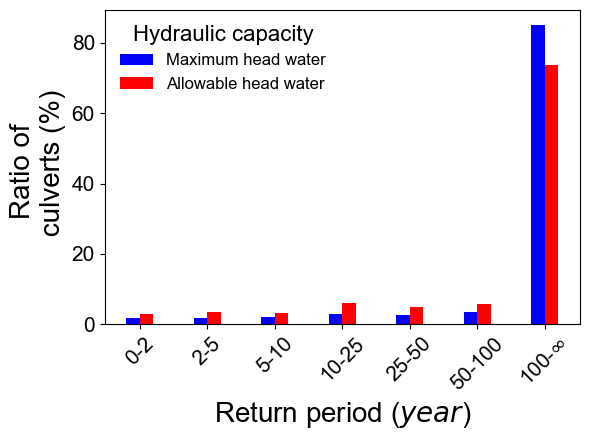

In [216]:
# Define ordered class labels
ordered_classes = ['0-2', '2-5', '5-10', '10-25', '25-50', '50-100', '100-200', '200-500', '500-1000', '1000-$∞$']
ordered_classes = ['0-2', '2-5', '5-10', '10-25', '25-50', '50-100', '100-$∞$']
# Convert RP_class and RP_class_c to ordered categorical
merged_culvert['RP_class'] = pd.Categorical(merged_culvert['RP_class'], categories=ordered_classes, ordered=True)
merged_culvert['RP_class_c'] = pd.Categorical(merged_culvert['RP_class_c'], categories=ordered_classes, ordered=True)
# Count occurrences for each category
counts_rp = merged_culvert['RP_class'].value_counts().reindex(ordered_classes).fillna(0)
counts_rp_c = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
# Convert to percentage
total = len(merged_culvert)
percent_rp = (counts_rp / total) * 100
percent_rp_c = (counts_rp_c / total) * 100
# figure
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')
# Bar positions
x = np.arange(len(ordered_classes))
bar_width = 0.2
# Plot side-by-side bars
bars_rp = ax.bar(x - bar_width / 2, percent_rp, width=bar_width, color='blue', alpha=1, label='Maximum head water')
bars_rp_c = ax.bar(x + bar_width / 2, percent_rp_c, width=bar_width, color='red', alpha=1, label='Allowable head water')
# Labels and formatting
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=15)
ax.tick_params(axis='y', labelsize=15)
# Add legend
ax.legend(title='Hydraulic capacity', title_fontsize=16, fontsize=12, loc='upper left', frameon=False)
# Layout
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_criteria_All.png", dpi=300, bbox_inches='tight')
plt.show()

#### Expected number of culverts that exceed their capacities (manual criteria)


In [273]:
merged_culvert[merged_culvert['reason'] == 'accurate']['RP_class_c_LL'].value_counts().sum()

np.int64(2381)

In [275]:
merged_culvert[merged_culvert['reason'] == 'accurate']['RP_class_c_UL'].value_counts()

RP_class_c_UL
100-$∞$    2317
50-100       22
10-25        19
25-50        14
5-10          6
2-5           3
Name: count, dtype: int64

In [203]:
(81+97+114+121+146)/2381

0.23477530449391013

In [ ]:
merged_culvert[merged_culvert.reason==accurate']['RP_class_c'].value_counts().reindex(ordered_classes)

RP_class_c
0-2         200
2-5         227
5-10        213
10-25       406
25-50       336
50-100      393
100-$∞$    4957
Name: count, dtype: int64

In [205]:
np.shape(merged_culvert)

(6732, 483)

In [350]:
exceed_proba_low_n=[0.5,0.2,0.1,0.04,0.02,0.01,0]
exceed_prob_up_b=[1,0.5,0.2,0.1,0.04,0.02,0.01 ]
counts = merged_culvert['RP_class'].value_counts().reindex(ordered_classes).fillna(0)
expec_num_exceed_low = sum(counts.iloc[i] * prob for i, prob in enumerate(exceed_proba_low_n))
expec_num_exceed_up=sum(counts.iloc[i] * prob for i, prob in enumerate(exceed_prob_up_b))
print(f'The expected ratio of annual culverts exceedance each year is ({(expec_num_exceed_low/np.shape(merged_culvert)[0])*100:.0f},\
 {(expec_num_exceed_up/np.shape(merged_culvert)[0])*100:.0f})%')

The expected ratio of annual culverts exceedance each year is (2, 4)%


In [351]:
exceed_proba_low_n=[0.5,0.2,0.1,0.04,0.02,0.01,0]
exceed_prob_up_b=[1,0.5,0.2,0.1,0.04,0.02,0.01 ]
counts = merged_culvert['RP_class'].value_counts().reindex(ordered_classes).fillna(0)
expec_num_exceed_low = sum(counts.iloc[i] * prob for i, prob in enumerate(exceed_proba_low_n))
expec_num_exceed_up=sum(counts.iloc[i] * prob for i, prob in enumerate(exceed_prob_up_b))
print(f'The expected number of annual culverts exceedance is ({expec_num_exceed_low.round(0)}, {expec_num_exceed_up.round(0)})')

The expected number of annual culverts exceedance is (113.0, 300.0)


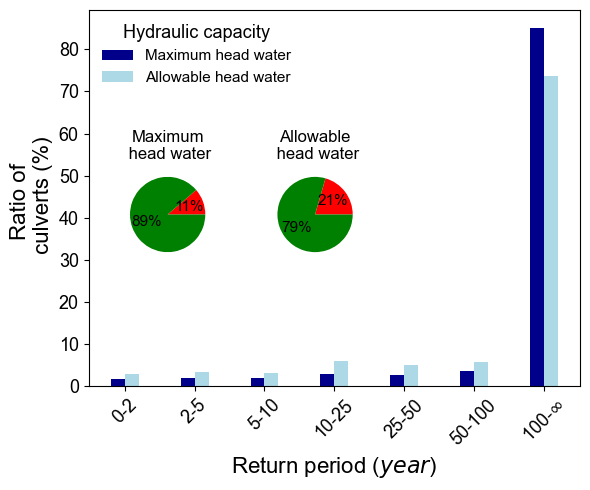

In [352]:
# Define ordered class labels
ordered_classes = ['0-2', '2-5', '5-10', '10-25', '25-50', '50-100', '100-200', '200-500', '500-1000', '1000-$∞$']
ordered_classes = ['0-2', '2-5', '5-10', '10-25', '25-50', '50-100', '100-$∞$']
merged_culvert['RP_class'] = pd.Categorical(merged_culvert['RP_class'], categories=ordered_classes, ordered=True)
merged_culvert['RP_class_c'] = pd.Categorical(merged_culvert['RP_class_c'], categories=ordered_classes, ordered=True)

# Count and calculate percentages
counts_rp = merged_culvert['RP_class'].value_counts().reindex(ordered_classes).fillna(0)
counts_rp_c = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
total = len(merged_culvert)
percent_rp = (counts_rp / total) * 100
percent_rp_c = (counts_rp_c / total) * 100

# Prepare pie data
short_classes = ['0-2', '2-5', '5-10', '10-25','25-50']
short_rp = counts_rp[short_classes].sum()
long_rp = counts_rp.drop(short_classes).sum()
short_rp_c = counts_rp_c[short_classes].sum()
long_rp_c = counts_rp_c.drop(short_classes).sum()

# Main figure
fig, ax = plt.subplots(figsize=(6, 5))  # slightly increased for space
fig.patch.set_facecolor('white')

# Bar plot
x = np.arange(len(ordered_classes))
bar_width = 0.2
bars_rp = ax.bar(x - bar_width / 2, percent_rp, width=bar_width, color='darkblue', alpha=1, label='Maximum head water')
bars_rp_c = ax.bar(x + bar_width / 2, percent_rp_c, width=bar_width, color='lightblue', alpha=1, label='Allowable head water')  # light brown
ax.set_xlabel('Return period ($year$)', fontsize=16)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.legend(title='Hydraulic capacity', title_fontsize=13, fontsize=11, loc='upper left', frameon=False)

# Inset pie for RP_class (top right)
axins1 = inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.7, -0.4, 1, 1),
                    bbox_transform=ax.transAxes,
                    )
axins1.pie([short_rp, long_rp], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins1.set_title('Maximum\n head water', fontsize=12)

# Inset pie for RP_class_c (just below the first)
axins2 = inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.4, -0.4, 1, 1),
                    bbox_transform=ax.transAxes,
                    )
axins2.pie([short_rp_c, long_rp_c], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins2.set_title('Allowable\n head water', fontsize=12)

plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_criteria_with_pie_inset_All.png", dpi=300, bbox_inches='tight')
plt.show()

## Too small or too large culverts 

## capacity to deisgn load ratio

In [209]:
# load rise data
rise_path=r"D:\hydrological analysis\data\rise\output_best.csv"
rise_df = pd.read_csv(rise_path)
rise_df['DESIGN TYPE'] = pd.to_numeric(rise_df['DESIGN TYPE'], errors='coerce') # change type of column DESIGN TYPE to float
confi_rise_BIN=list(rise_df[(~rise_df['Height'].isna()) | (rise_df['DESIGN TYPE'].isin([41, 42])) & (rise_df["NUMBER OF MAIN SPANS"] == 1)].BIN)
sum(merged_culvert['BIN'].isin(confi_rise_BIN))# number of culverts with confident rises


4812

In [210]:
merged_culvert=merged_culvert[merged_culvert['BIN'].isin(confi_rise_BIN)]

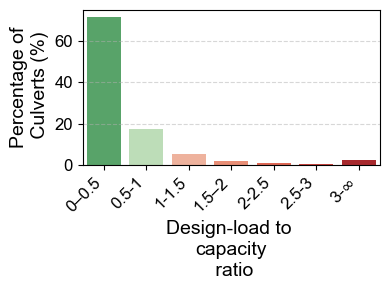

In [295]:
# Define 3 classes
bins = [0, 0.5, 1,1.5, 2,2.5,3, float('inf')]
labels = ['0–0.5','0.5-1','1-1.5', '1.5–2', '2-2.5',
          '2.5-3','3-$∞$']
# Compute allowable HW/D ratio
merged_culvert['load_cap_ratio'] = 1/(merged_culvert['average_Q_maxhw'] / merged_culvert['Q_50'])
# Assign class labels
merged_culvert['class_allowable'] = pd.cut(
    merged_culvert['load_cap_ratio'],
    bins=bins,
    labels=labels,
    right=False
)
# Calculate percentage counts
allowable_counts = (
    merged_culvert['class_allowable']
    .value_counts(normalize=True)
    .reindex(labels)
    .fillna(0) * 100
)
# Convert to DataFrame
df_plot = pd.DataFrame({
    'Class': labels,
    'Percentage': allowable_counts.values
})
# Create green-to-red color palette (reversed RdYlGn)
green_cmap = get_cmap('Greens_r')
red_cmap = get_cmap('Reds')

# Number of bins
num_green = 2
num_red = len(labels) - num_green

# Generate shades
green_shades = [green_cmap(0.4 + 0.3 * (i / max(num_green - 1, 1))) for i in range(num_green)]
red_shades = [red_cmap(0.3 + 0.5 * (i / max(num_red - 1, 1))) for i in range(num_red)]

# Combine
custom_colors = green_shades + red_shades

# Plot
plt.figure(figsize=(4, 3))
plt.grid(axis='y', which='major', linestyle="--", alpha=0.5)
sns.barplot(data=df_plot, x='Class', y='Percentage', palette=custom_colors)
plt.ylabel('Percentage of\n Culverts (%)', fontsize=14)
plt.xlabel('Design-load to \ncapacity\n ratio', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\his_load_cap_ratio_custom_palette_All.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
excel_output_file = r"D:\culvert repo\data\rise\culvert dataframe  with height.xlsx"
culvert_func=pd.read_excel(excel_output_file)
# Merge the two datasets on 'BIN'
merged_culvert = merged_culvert.merge(
    culvert_func[['BIN', 'MAXIMUM SPAN LENGTH (FT)','Height']], 
    on='BIN', 
    how='inner'
)

In [546]:
# Select and report the culverts with 
#merged_culvert=merged_culvert[(merged_culvert['load_cap_ratio']>2.5)|(merged_culvert['load_cap_ratio']<.5)].iloc[:10,:]

merged_culvert=merged_culvert[(merged_culvert['load_cap_ratio']>2.5)|(merged_culvert['load_cap_ratio']<.5)] 
merged_culvert[['BIN','MAXIMUM SPAN LENGTH (FT)','Height','Area','Q_50','average_Q_maxhw', 'load_cap_ratio','RP_class_c']]\
    .to_excel(r'D:\culvert repo\Results\subgroups\large_disparities_cap_load.xlsx')


## Map

In [28]:
# merge with shapefile
culvert1 = gpd.read_file(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc.shp')
#culvert1.columns
gdf = merged_culvert.merge(culvert1[['BIN','geometry']], on='BIN', how='inner')

In [29]:
# Gdf has'Ini_lat' and 'Ini_lon' columns
geometry = [Point(xy) for xy in zip(gdf['Ini_lon'], gdf['Ini_lat'])]
gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs='EPSG:4326')
gdf1=gdf

## Underdesinged culverts return periods

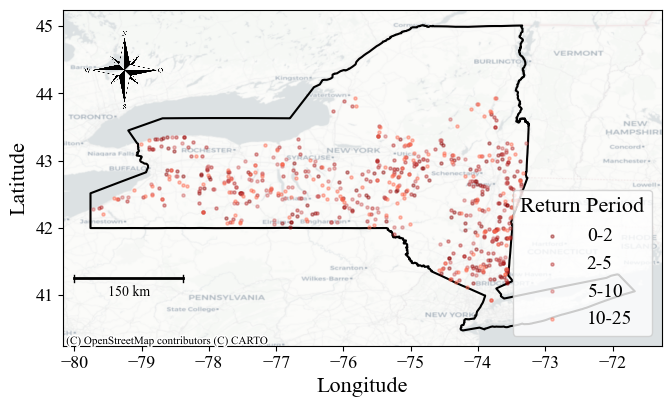

In [ ]:
# Reproject GeoDataFrame for basemap
gdf = gdf1.to_crs(epsg=4326)

# Define red classes only (short return periods)
short_classes = ['0-2', '2-5', '5-10', '10-25']
class_colors = {
    '0-2': 'darkred',
    '2-5': 'firebrick',
    '5-10': 'indianred',
    '10-25': 'tomato'
}

# Create figure
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

# Plot only short return period classes
for rp_class in short_classes:
    subset = gdf[gdf['RP_class_c'] == rp_class]
    if subset.empty:
        continue
    subset.plot(ax=ax, marker='o', color=class_colors[rp_class], markersize=5, label=rp_class, alpha=0.4)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)

# Estimate meters per degree using NYS bounding box
minx, miny, maxx, maxy = state_shapefile.total_bounds
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs='EPSG:4326')
bbox_5070 = bbox_gdf.to_crs('EPSG:5070')
scale_width_m = bbox_5070.geometry[0].bounds[2] - bbox_5070.geometry[0].bounds[0]
scale_width_deg = maxx - minx
meters_per_degree = scale_width_m / scale_width_deg

# Add scale bar
bar_length_km = 150
deg_per_km = 1 / (meters_per_degree / 1000)
bar_length_deg = bar_length_km * deg_per_km

bar_x_start = -80  # adjust based on your extent
bar_x_end = bar_x_start + bar_length_deg
bar_y = 41.25

# Draw scale bar line and ticks
ax.plot([bar_x_start, bar_x_end], [bar_y, bar_y], color='black', lw=2)
ax.plot([bar_x_start, bar_x_start], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)
ax.plot([bar_x_end, bar_x_end], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)

# Add scale bar label
ax.text(
    (bar_x_start + bar_x_end) / 2,
    bar_y - 0.1,
    f'{bar_length_km} km',
    ha='center',
    va='top',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=.1, edgecolor='none', boxstyle='round,pad=0.2')
)
# Add north arrow (manual placement in top-left)
# Add north arrow image
img_path = r'D:\culvert repo\Results\north_arrow\N_arrow.png'
north_img = mpimg.imread(img_path)
imagebox = OffsetImage(north_img, zoom=0.09)  # Adjust zoom as needed
ab = AnnotationBbox(imagebox, (0.1, 0.82), xycoords='axes fraction', frameon=False)
ax.add_artist(ab)

# Format legend and axes
plt.legend(
    title="Return Period",
    fontsize=14,
    title_fontsize=16,
    loc='lower right',
    frameon=True
)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)

# Layout and save
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_return_periods_map_short_only_All.png', dpi=300, bbox_inches='tight')
plt.show()

## All culverts return periods

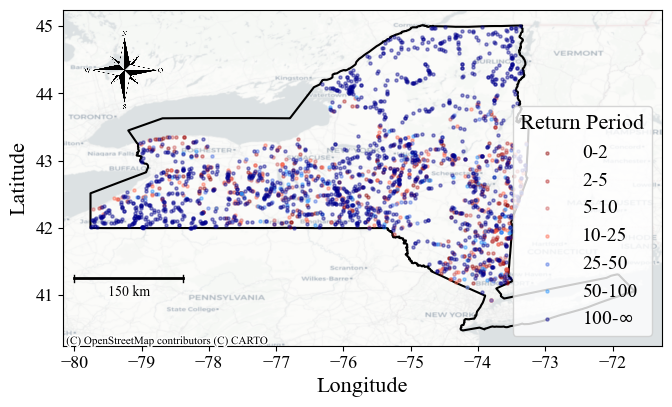

In [24]:
# Reproject GeoDataFrame for basemap
gdf = gdf1.to_crs(epsg=4326)
state_shapefile = state_shapefile.to_crs(epsg=4326)

class_colors = {
    '0-2': 'darkred',
    '2-5': 'firebrick',
    '5-10': 'indianred',
    '10-25': 'tomato',
    '25-50': 'royalblue',
    '50-100': 'dodgerblue',
    '100-$∞$': 'darkblue'
}
ordered_classes = list(class_colors.keys())

# Create figure
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

# Plot each return period class
for rp_class in ordered_classes:
    subset = gdf[gdf['RP_class_c'] == rp_class]
    if subset.empty:
        continue
    color = class_colors[rp_class]
    subset.plot(ax=ax, marker='o', color=color, markersize=5, label=rp_class, alpha=0.4)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)

# --- SCALE BAR ---
# Estimate meters per degree using bounding box
minx, miny, maxx, maxy = state_shapefile.total_bounds
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs='EPSG:4326')
bbox_5070 = bbox_gdf.to_crs('EPSG:5070')
scale_width_m = bbox_5070.geometry[0].bounds[2] - bbox_5070.geometry[0].bounds[0]
scale_width_deg = maxx - minx
meters_per_degree = scale_width_m / scale_width_deg

bar_length_km = 150
deg_per_km = 1 / (meters_per_degree / 1000)
bar_length_deg = bar_length_km * deg_per_km

# --- Do NOT modify this ---
bar_x_start = -80  # adjust based on your extent
bar_x_end = bar_x_start + bar_length_deg
bar_y = 41.25

# Draw scale bar
ax.plot([bar_x_start, bar_x_end], [bar_y, bar_y], color='black', lw=2)
ax.plot([bar_x_start, bar_x_start], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)
ax.plot([bar_x_end, bar_x_end], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)

# Add label with frame
ax.text(
    (bar_x_start + bar_x_end) / 2,
    bar_y - 0.1,
    f'{bar_length_km} km',
    ha='center',
    va='top',
    fontsize=10,
    family='Times New Roman',
    bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.2')
)

# --- NORTH ARROW ---
img_path = r'D:\culvert repo\Results\north_arrow\N_arrow.png'
north_img = mpimg.imread(img_path)
imagebox = OffsetImage(north_img, zoom=0.09)  # <-- keep this as is
ab = AnnotationBbox(imagebox, (0.1, 0.82), xycoords='axes fraction', frameon=False)  # <-- keep this as is
ax.add_artist(ab)

# Legend and formatting
plt.legend(
    title="Return Period",
    fontsize=14,
    title_fontsize=16,
    loc='lower right',
    frameon=True
)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)

# Layout and save
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_return_periods_map_class_All.png', dpi=300, bbox_inches='tight')
plt.show()


In [133]:
merged_culvert.columns

Index(['BIN', 'Ini_lon', 'Ini_lat', 'lonsnap_10', 'latsnap_10', 'Area_10',
       'Peri_10', 'LFP_len_10', 'LFP_S_10', 'Bas_S_10',
       ...
       'Q_LL_500', 'Q_LL_1000', 'RP', 'RP_class', 'RP_c', 'RP_class_c',
       'RP_c_LL', 'RP_class_c_LL', 'RP_c_UL', 'RP_class_c_UL'],
      dtype='object', length=606)

# Uncertainty bounds

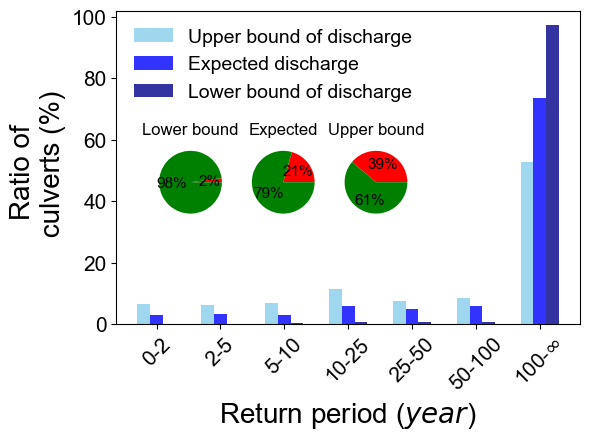

In [353]:
# Convert all class columns to ordered categorical
for col in ['RP_class_c', 'RP_class_c_LL', 'RP_class_c_UL']:
    merged_culvert[col] = pd.Categorical(merged_culvert[col], categories=ordered_classes, ordered=True)
# Compute percentage counts
total = len(merged_culvert)
percent_c = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0) / total * 100
percent_c_LL = merged_culvert['RP_class_c_LL'].value_counts().reindex(ordered_classes).fillna(0) / total * 100
percent_c_UL = merged_culvert['RP_class_c_UL'].value_counts().reindex(ordered_classes).fillna(0) / total * 100

# Short vs long return period class categories
short_classes = ['0-2', '2-5', '5-10', '10-25','25-50']
long_classes = [ '50-100', '100-$∞$']

# Count short vs long for each uncertainty level
def count_short_long(series):
    short = series.isin(short_classes).sum()
    long = series.isin(long_classes).sum()
    return short, long

short_c, long_c = count_short_long(merged_culvert['RP_class_c'])
short_LL, long_LL = count_short_long(merged_culvert['RP_class_c_LL'])
short_UL, long_UL = count_short_long(merged_culvert['RP_class_c_UL'])

# Bar positions
x = np.arange(len(ordered_classes))
bar_width = 0.2
# Create plot
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')
# Plot bars
ax.bar(x - bar_width, percent_c_LL, width=bar_width, label='Upper bound of discharge', color='skyblue', alpha=0.8)
ax.bar(x, percent_c, width=bar_width, label='Expected discharge', color='blue', alpha=0.8)
ax.bar(x + bar_width, percent_c_UL, width=bar_width, label='Lower bound of discharge', color='darkblue', alpha=0.8)

# Add pie chart for Upper bound
axins3 = inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.7, -0.4, 1, 1),
                    bbox_transform=ax.transAxes)
axins3.pie([short_UL, long_UL], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins3.set_title('Lower bound', fontsize=12)

# Add pie chart for Expected discharge
axins1 = inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.5, -0.4, 1, 1),
                    bbox_transform=ax.transAxes,
                    )

axins1.pie([short_c, long_c], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins1.set_title('Expected', fontsize=12)

# Add pie chart for Lower bound
axins2 =  inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.3, -0.4, 1, 1),
                    bbox_transform=ax.transAxes,
                    )
axins2.pie([short_LL, long_LL], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins2.set_title('Upper bound', fontsize=12)

# Axis and label formatting
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=15)
ax.tick_params(axis='y', labelsize=15)
# Legend
ax.legend(fontsize=14, loc='upper left', frameon=False)
# Layout adjustment
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_Uncertainty_bounds_all.png", dpi=300, bbox_inches='tight')
plt.show()

# ASM

In [ ]:
# Convert class columns to ordered categorical
for col in ['RP_class_c', 'RP_class_c_nor', 'RP_class_c_dry']:
    merged_culvert[col] = pd.Categorical(merged_culvert[col], categories=ordered_classes, ordered=True)
# Total number of culverts
total = len(merged_culvert)
# Compute percentage counts for each class column
percent_c = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0) / total * 100
percent_c_nor = merged_culvert['RP_class_c_nor'].value_counts().reindex(ordered_classes).fillna(0) / total * 100
percent_c_dry = merged_culvert['RP_class_c_dry'].value_counts().reindex(ordered_classes).fillna(0) / total * 100
# Generate the pie chart data
short_dry, long_dry = count_short_long(merged_culvert['RP_class_c_dry'])
short_nor, long_nor = count_short_long(merged_culvert['RP_class_c_nor'])
short_wet, long_wet = count_short_long(merged_culvert['RP_class_c'])

# X-axis setup
x = np.arange(len(ordered_classes))
bar_width = 0.2
# Create the figure
fig, ax = plt.subplots(figsize=(6, 4.5))
fig.patch.set_facecolor('white')
# Plot each bar group
ax.bar(x - bar_width, percent_c_dry, width=bar_width, label='Dry', color='red')
ax.bar(x, percent_c_nor, width=bar_width, label='Normal', color='gold')
ax.bar(x + bar_width, percent_c, width=bar_width, label='Wet', color='blue')
# Pie for Dry
axins1 = inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.7, -0.5, 1, 1),
                    bbox_transform=ax.transAxes)
axins1.pie([short_dry, long_dry], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins1.set_title('Dry', fontsize=12)

# Pie for Normal
axins2 = inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.5, -0.5, 1, 1),
                    bbox_transform=ax.transAxes)
axins2.pie([short_nor, long_nor], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins2.set_title('Normal', fontsize=12)

# Pie for Wet
axins3 = inset_axes(ax, width="25%", height="25%", 
                    bbox_to_anchor=(-0.3, -0.5, 1, 1),
                    bbox_transform=ax.transAxes)
axins3.pie([short_wet, long_wet], colors=['red', 'green'], 
           autopct='%1.0f%%', textprops={'fontsize': 11})
axins3.set_title('Wet', fontsize=12)
# Formatting
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(title='AMC',title_fontsize=16, fontsize=12, loc='upper left', frameon=False)
# Final layout adjustment
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_ASM.png", dpi=300, bbox_inches='tight')
plt.show()

# Future

## Landuse

In [ ]:
# Custom labels for x-axis (you can also just reuse ordered_classes if they’re final)
custom_labels = ordered_classes
# Define year and scenario list
years = [2030,2060,2090]
scenarios = ['B2', 'B1', 'A1B', 'A2']
# Define colors for the scenarios (light to dark)
palette = ['#6baed6', '#2171b5', '#ef3b2c', '#99000d']
scenario_labels = ['B2', 'B1', 'A1B', 'A2']
# Function to compute percentage distribution for a given year
def get_percentages_for_year(year):
    columns = [f'RP_class_c_{year}_{sc}' for sc in scenarios]
    counts = [merged_culvert[col].value_counts().reindex(ordered_classes, fill_value=0) for col in columns]
    percentages = [(c / c.sum()) * 100 for c in counts]
    return percentages
# Set up the subplots
ncols = 4
nrows = int(np.ceil(len(years) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharey=True)
fig.patch.set_facecolor('white')

bar_width = 0.2
x = np.arange(len(ordered_classes))
# Plotting function
def plot_bars(ax, percentages, title, year):
    for i, (percent, color, label) in enumerate(zip(percentages, palette, scenario_labels)):
        ax.bar(x - 1.5 * bar_width + i * bar_width, percent, width=bar_width, label=label, color=color, alpha=0.8)

        # Pie chart: count short/long culverts for this scenario and year
        colname = f'RP_class_c_{year}_{label}'
        short, long = count_short_long(merged_culvert[colname])

        # Define inset position (horizontally staggered)
        inset_x = -0.7 + 0.15 * i
        axins = inset_axes(ax, width="25%", height="25%", 
                           bbox_to_anchor=(inset_x, -0.15, 1, 1), 
                           bbox_transform=ax.transAxes)
        axins.pie([short, long], colors=['red', 'green'],
                  autopct='%1.0f%%', textprops={'fontsize': 11})
        axins.set_title(label, fontsize=12)
        
    ax.set_xticks(x)
    ax.set_xticklabels(custom_labels, rotation=45, ha='center', fontsize=15)
    ax.set_xlabel('Return period (years)', fontsize=15)
    ax.set_title(title, fontsize=15)
# Loop through years and plot each
for idx, year in enumerate(years):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    percentages = get_percentages_for_year(year)
    plot_bars(ax, percentages, f'{year}', year)

    if col == 0:
        ax.set_ylabel('Ratio of \nculverts (%)', fontsize=15)
# Hide unused subplots if total < nrows * ncols
for i in range(len(years), nrows * ncols):
    row = i // ncols
    col = i % ncols
    fig.delaxes(axes[row, col] if nrows > 1 else axes[col])
# Create a single legend
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i], alpha=0.8) for i in range(len(scenario_labels))]
fig.legend(handles, scenario_labels, title='Scenario',title_fontsize=16, loc='upper center', bbox_to_anchor=(0.4, 1.05),
           ncol=4, fontsize=12, frameon=True)
# Layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.90])
# Save figure
plt.savefig(r'D:\culvert repo\Results\Figures\hist_returnperiods_percentages_future_scenarios_all_years.png', 
            dpi=300, bbox_inches='tight')
# Show plot
plt.show()

## Percipitation

In [ ]:
# Define the ordered classes and custom labels
ordered_classes = ['0-2', '2-5', '5-10', '10-25', '25-50', '50-100','100-$∞$']
custom_labels = ordered_classes
# Time periods and RCP scenarios
scenarios = ['rcp45', 'rcp85']
scenario_labels = ['RCP4.5', 'RCP8.5']
times = ['2010-2039', '2040-2069', '2070-2099']
# Updated color palette: RCP4.5 (blue), RCP8.5 (dark red)
palette = ['#6baed6', '#99000d']
# Function to get normalized percentages
def get_percentages(columns):
    counts = [merged_culvert[col].value_counts().reindex(ordered_classes, fill_value=0) for col in columns]
    percentages = [(c / c.sum()) * 100 for c in counts]
    return percentages
# Gather percentage data for each time period
percentages_2030 = get_percentages([f'RP_class_c_2010-2039_{s}' for s in scenarios])
percentages_2060 = get_percentages([f'RP_class_c_2040-2069_{s}' for s in scenarios])
percentages_2090 = get_percentages([f'RP_class_c_2070-2099_{s}' for s in scenarios])
# Set up the plots
fig, axes = plt.subplots(1, 3, figsize=(4*3, 4), sharey=True)
fig.patch.set_facecolor('white')
x = np.arange(len(ordered_classes))
bar_width = 0.2
# Bar plotting function
def plot_bars(ax, percentages, title, columns):
    for i, (percent, color) in enumerate(zip(percentages, palette)):
        ax.bar(x - 0.5 * bar_width + i * bar_width, percent, width=bar_width, 
               label=scenario_labels[i], color=color, alpha=0.8)
        
        # Pie chart for short vs long
        short, long = count_short_long(merged_culvert[columns[i]])
        axins = inset_axes(ax, width="25%", height="25%", 
                           bbox_to_anchor=(-0.6 + i * 0.25, -0.15, 1, 1),
                           bbox_transform=ax.transAxes)
        axins.pie([short, long], colors=['red', 'green'],
                  autopct='%1.0f%%', textprops={'fontsize': 11})
        axins.set_title(scenario_labels[i], fontsize=12)
        
    ax.set_xticks(x)
    ax.set_xticklabels(custom_labels, rotation=45, ha='center', fontsize=15)
    ax.set_xlabel('Return period (years)', fontsize=15)
    ax.set_title(title, fontsize=15)

# Plotting each time slice
plot_bars(axes[0], percentages_2030, '2030', [f'RP_class_c_2010-2039_{s}' for s in scenarios])
plot_bars(axes[1], percentages_2060, '2060', [f'RP_class_c_2040-2069_{s}' for s in scenarios])
plot_bars(axes[2], percentages_2090, '2090', [f'RP_class_c_2070-2099_{s}' for s in scenarios])
# Add Y-axis label to the first plot
axes[0].set_ylabel('Ratio of \nculverts (%)', fontsize=15)
# Add legend above all plots
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i], alpha=0.8) for i in range(len(scenario_labels))]
fig.legend(handles, scenario_labels, title='Scenario',title_fontsize=16, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=12, frameon=True)
# Final layout adjustments and save
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(r'D:\culvert repo\Results\Figures\hist_returnperiods_percentages_rcp_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()

## Landuse and percipitation

In [ ]:
# Define RP class bins
ordered_classes = ['0-2', '2-5', '5-10', '10-25', '25-50', '50-100', '100-$∞$']
custom_labels = ordered_classes

# Future years and scenarios
years = [2030, 2060, 2090]
scenarios = ['B2', 'A2']  # B2 = rcp45 (lower), A2 = rcp85 (upper)
scenario_labels = ['Lower Bound', 'Upper Bound']
palette = ['#6baed6', '#99000d']

# Function to calculate percentage histogram for a given year and scenario
def get_percentages(year, scenario):
    col = f'RP_class_c_{year}_{scenario}_lr'
    if col in merged_culvert.columns:
        counts = merged_culvert[col].value_counts().reindex(ordered_classes, fill_value=0)
        return (counts / counts.sum()) * 100
    else:
        return pd.Series([0]*len(ordered_classes), index=ordered_classes)

# Set up the figure with 3 subplots for the years
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.patch.set_facecolor('white')
x = np.arange(len(ordered_classes))
bar_width = 0.2

# Bar plotting function for each year
def plot_bars(ax, year):
    for i, scenario in enumerate(scenarios):
        colname = f'RP_class_c_{year}_{scenario}_lr'
        percent = get_percentages(year, scenario)

        # Plot bar
        ax.bar(
            x - 0.5 * bar_width + i * bar_width,
            percent,
            width=bar_width,
            label=scenario_labels[i],
            color=palette[i],
            alpha=0.8
        )

        # Pie chart: short vs long RP classes
        if colname in merged_culvert.columns:
            short, long = count_short_long(merged_culvert[colname])
            axins = inset_axes(ax, width="25%", height="25%", 
                               bbox_to_anchor=(-0.6 + 0.4 * i, -0.15, 1, 1),
                               bbox_transform=ax.transAxes)
            axins.pie([short, long], colors=['red', 'green'], 
                      autopct='%1.0f%%', textprops={'fontsize': 11})
            axins.set_title(scenario_labels[i], fontsize=12)

    ax.set_xticks(x)
    ax.set_xticklabels(custom_labels, rotation=45, ha='center', fontsize=12)
    ax.set_xlabel('Return Period (years)', fontsize=13)
    ax.set_title(f'{year} Projections', fontsize=13)

# Plot each year in its subplot
for ax, year in zip(axes, years):
    plot_bars(ax, year)

# Y-axis label only on first plot
axes[0].set_ylabel('Ratio of Culverts (%)', fontsize=13)

# Shared legend above all plots
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i], alpha=0.8) for i in range(len(scenario_labels))]
fig.legend(handles, scenario_labels, title='Scenario', title_fontsize=14,
           loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2, fontsize=12, frameon=True)

# Final layout and save
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(r'D:\culvert repo\Results\Figures\hist_returnperiods_percentages_2040_2070_2100.png', dpi=300, bbox_inches='tight')
plt.show()

## Conditionals 

### Rain type

#### Histogram

In [ ]:
# Define ordered class labels
merged_culvert['RP_class_c'] = pd.Categorical(merged_culvert['RP_class_c'], categories=ordered_classes, ordered=True)

# Total number of culverts (for marginal)
total_all = len(merged_culvert)

# Marginal (overall) histogram
counts_marginal = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
percent_marginal = (counts_marginal / total_all) * 100

# Conditional histograms
rain_types = merged_culvert['rain_type'].unique()
total_by_type = merged_culvert['rain_type'].value_counts()
colors = ['red', 'blue']

# X positions and bar widths
x = np.arange(len(ordered_classes))
marginal_width = 0.25*3
conditional_width = 0.25

# Initialize figure
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')

# Plot marginal histogram (background)
ax.bar(x, percent_marginal, width=marginal_width, color='gray', alpha=0.4, label='All')

# Plot conditional histograms by rain_type
for i, rain_type in enumerate(rain_types):
    subset = merged_culvert[merged_culvert['rain_type'] == rain_type]
    counts = subset['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
    percent = (counts / total_by_type[rain_type]) * 100
    bar_positions = x + (i - 0.5) * conditional_width  # Center the bars inside marginal
    ax.bar(bar_positions, percent, width=conditional_width,
           label=f'{rain_type}', color=colors[i], alpha=0.9)
    # pie
    short, long = count_short_long(subset['RP_class_c'])
    axins = inset_axes(ax, width="25%", height="25%",
                       bbox_to_anchor=(-0.65 + i * 0.2, -0.4, 1, 1),
                       bbox_transform=ax.transAxes)
    axins.pie([short, long], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
    axins.set_title(rain_type, fontsize=12)

# Add pie chart for marginal ("All")
short_all, long_all = count_short_long(merged_culvert['RP_class_c'])
axins_all = inset_axes(ax, width="25%", height="25%",
                       bbox_to_anchor=(-0.65 + 2 * 0.2, -0.4, 1, 1),
                       bbox_transform=ax.transAxes)
axins_all.pie([short_all, long_all], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
axins_all.set_title('All', fontsize=12)


# Labels and formatting
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(title='Rain type', title_fontsize=16,fontsize=12, loc='upper left', frameon=False)

# Layout and save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_by_rain_type_with_marginal.png", dpi=300, bbox_inches='tight')
plt.show()

#### Map

In [ ]:
# Define rain type colors (consistent with histogram)
rain_type_colors = {
    'II': 'blue',
    'III': 'red'
}
# Create the figure and axis
fig, ax = plt.subplots(figsize=(3*2.5, 4*2.5))
fig.patch.set_facecolor('white')
# Plot culverts by rain_type
for rain_type, color in rain_type_colors.items():
    subset = gdf[gdf['rain_type'] == rain_type]
    if subset.empty:
        continue
    subset.plot(ax=ax, marker='o', color=color, markersize=10, label=f'{rain_type}', alpha=0.5)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)
# Axis and legend formatting
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(
    title="Rain type",
    fontsize=12,
    title_fontsize=16,
    loc='upper left',
    frameon=True
)
# Finalize layout and save
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_rain_type_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Regions

In [ ]:
merged_culvert['RP_class_c'] = pd.Categorical(merged_culvert['RP_class_c'], categories=ordered_classes, ordered=True)
# Region label mapping
region_labels = {
    '1': 'Albany', '2': 'Utica', '3': 'Syracuse', '4': 'Rochester',
    '5': 'Buffalo', '6': 'Hornell', '7': 'Watertown', '8': 'Poughkeepsie',
    '9': 'Binghamton', '0': 'Hauppauge', 'N': 'New York City'
}
# Region label mapping
region_labels = {
    '1': 'Albany', '2': 'Utica', '3': 'Syracuse', '4': 'Rochester',
    '5': 'Buffalo', '6': 'Hornell', '7': 'Watertown', '8': 'Poughkeepsie',
    '9': 'Binghamton'}
# Filter only regions in the label map
regions = merged_culvert['REGION'].astype(str).isin(region_labels.keys())
merged_culvert = merged_culvert[regions].copy()
# Total (marginal) histogram
total_all = len(merged_culvert)
counts_marginal = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
percent_marginal = (counts_marginal / total_all) * 100
# Compute totals by region
merged_culvert['REGION_STR'] = merged_culvert['REGION'].astype(str)
total_by_region = merged_culvert['REGION_STR'].value_counts()
# Use a few distinct colors
region_codes = sorted(merged_culvert['REGION_STR'].unique())
color_map = plt.cm.get_cmap('tab10', len(region_codes))  # up to 10 regions
# Plot setup
x = np.arange(len(ordered_classes))
marginal_width = 0.08*10
conditional_width = 0.08
fig, ax = plt.subplots(figsize=(4*3, 3*1.5))
fig.patch.set_facecolor('white')
# Plot marginal bar
ax.bar(x, percent_marginal, width=marginal_width, color='gray', alpha=0.4, label='All')
# Conditional bars by region
for i, region in enumerate(region_codes):
    region_df = merged_culvert[merged_culvert['REGION_STR'] == region]
    counts = region_df['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
    percent = (counts / total_by_region[region]) * 100
    bar_positions = x + (i - len(region_codes)/2 +0.5) * conditional_width
    ax.bar(bar_positions, percent, width=conditional_width,
           label=f"{region_labels.get(region, region)}",
           color=color_map(i), alpha=0.9)
    short, long = count_short_long(region_df['RP_class_c'])

    # Adjust horizontal offset based on region index
    inset_x = -0.85 + i * 0.08
    axins = inset_axes(ax, width="20%", height="20%", 
                       bbox_to_anchor=(inset_x, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
    axins.pie([short, long], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 9})
    axins.set_title(region_labels.get(region, region), fontsize=10)

# Add pie chart for overall distribution
short_all, long_all = count_short_long(merged_culvert['RP_class_c'])
axins_all = inset_axes(ax, width="20%", height="20%",
                       bbox_to_anchor=(-0.85 + 9 * 0.08, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
axins_all.pie([short_all, long_all], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 9})
axins_all.set_title('All', fontsize=10)

# Axes and labels
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=15)
ax.tick_params(axis='y', labelsize=15)
# Legend
ax.legend(title='Region', title_fontsize=16,fontsize=12, loc='upper left', frameon=False, ncol=3)
# Save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_by_region_with_marginal.png", dpi=300, bbox_inches='tight')
plt.show()

#### Map

In [ ]:
# Region label mapping
region_labels = {
    '1': 'Albany', '2': 'Utica', '3': 'Syracuse', '4': 'Rochester',
    '5': 'Buffalo', '6': 'Hornell', '7': 'Watertown', '8': 'Poughkeepsie',
    '9': 'Binghamton', '0': 'Hauppauge', 'N': 'New York City'
}
# Region label mapping
region_labels = {
    '1': 'Albany', '2': 'Utica', '3': 'Syracuse', '4': 'Rochester',
    '5': 'Buffalo', '6': 'Hornell', '7': 'Watertown', '8': 'Poughkeepsie',
    '9': 'Binghamton'}
# Filter only regions in the label map and convert to string
gdf['REGION_STR'] = gdf['REGION'].astype(str)
gdf = gdf[gdf['REGION_STR'].isin(region_labels.keys())]

# Get sorted region codes and color map
region_codes = sorted(gdf['REGION_STR'].unique())
color_map = plt.cm.get_cmap('tab10', len(region_codes))  # Consistent with histogram

# Create figure
fig, ax = plt.subplots(figsize=(3*2.5, 4*2.5))
fig.patch.set_facecolor('white')

# Plot culverts by region
for i, region_code in enumerate(region_codes):
    subset = gdf[gdf['REGION_STR'] == region_code]
    region_name = region_labels.get(region_code, region_code)
    subset.plot(ax=ax, marker='o', color=color_map(i), markersize=10,
                label=f'{region_name}', alpha=0.6)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)

# Axis and legend formatting
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(title="Region", fontsize=12, title_fontsize=16,
           loc='upper left', ncol=3, frameon=True)

# Finalize and save
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_regions_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Design type

In [ ]:
# Design type mapping
design_mapping = {
    41: 'Circular', 42: 'Circular',
    25: 'Oval', 26: 'Oval',
    40: 'Rectangular', 43: 'Rectangular'
}
# Map design types
merged_culvert['Design Category'] = merged_culvert['DESIGN TYPE'].map(design_mapping)
# Exclude unrecognized types from conditional plot
filtered_culvert = merged_culvert.dropna(subset=['Design Category'])
# Marginal histogram (all culverts including "Other Design Types")
total_all = len(merged_culvert)
counts_marginal = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
percent_marginal = (counts_marginal / total_all) * 100
# Unique design categories and totals
design_categories = sorted(filtered_culvert['Design Category'].unique())
category_totals = filtered_culvert['Design Category'].value_counts()
# Plot setup
x = np.arange(len(ordered_classes))
marginal_width = 0.2*4
conditional_width = 0.2
color_map = {'Circular': 'blue', 'Oval': 'green', 'Rectangular': 'red'}
# Create figure
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')
# Plot marginal histogram
ax.bar(x, percent_marginal, width=marginal_width, color='gray', alpha=0.4, label='All')
# Conditional histograms by design category
for i, design in enumerate(design_categories):
    subset = filtered_culvert[filtered_culvert['Design Category'] == design]
    counts = subset['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
    percent = (counts / category_totals[design]) * 100
    bar_positions = x + (i - len(category_totals)/2 +0.5) * conditional_width
    ax.bar(bar_positions, percent, width=conditional_width,
           label=f'{design}', color=color_map[design], alpha=0.9)
    short, long = count_short_long(subset['RP_class_c'])

    axins = inset_axes(ax, width="25%", height="25%",
                       bbox_to_anchor=(-0.75 + i * 0.2, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
    axins.pie([short, long], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
    axins.set_title(design, fontsize=12)

# Pie chart for marginal (all culverts)
short_all, long_all = count_short_long(merged_culvert['RP_class_c'])
axins_all = inset_axes(ax, width="25%", height="25%",
                       bbox_to_anchor=(-0.75 + 3 * 0.2,-0.5, 1, 1),
                       bbox_transform=ax.transAxes)
axins_all.pie([short_all, long_all], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
axins_all.set_title("All", fontsize=12)
    

# Labels and formatting
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title='Design type',title_fontsize=16, fontsize=12, loc='upper left', frameon=False)
# Save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_by_design_type.png", dpi=300, bbox_inches='tight')
plt.show()

#### Map

In [ ]:
# Design type mapping
design_mapping = {
    41: 'Circular', 42: 'Circular',
    25: 'Oval', 26: 'Oval',
    40: 'Rectangular', 43: 'Rectangular'
}
gdf['Design Category'] = gdf['DESIGN TYPE'].map(design_mapping)
# Filter culverts with valid design category
gdf = gdf.dropna(subset=['Design Category'])
# Color map used in histogram
color_map = {'Circular': 'blue', 'Oval': 'green', 'Rectangular': 'red'}
# List design categories in consistent order
design_categories = sorted(gdf['Design Category'].unique())
# Create the figure
fig, ax = plt.subplots(figsize=(3*2.5, 4*2.5))
fig.patch.set_facecolor('white')
# Plot culverts by design category
for design in design_categories:
    subset = gdf[gdf['Design Category'] == design]
    subset.plot(ax=ax, marker='o', color=color_map[design], markersize=10,
                label=f'{design}', alpha=0.6)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)
# Format axes and legend
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(title="Design type", fontsize=12, title_fontsize=16,
           loc='upper left', frameon=True)
# Save and show
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_design_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Functional categories

In [165]:
excel_output_file = r"D:\culvert repo\data\rise\culvert dataframe  with height.xlsx"
culvert_func=pd.read_excel(excel_output_file)

In [166]:
# Merge the two datasets on 'BIN'
merged_culvert = merged_culvert.merge(
    culvert_func[['BIN', 'FUNCTIONAL CLASSIFICATION']], 
    on='BIN', 
    how='inner'
)

In [ ]:
# Simplified functional class mapping
functional_class_mapping = {
    1: 'Interstate', 11: 'Interstate',
    2: 'Arterial', 6: 'Arterial', 12: 'Arterial', 14: 'Arterial', 16: 'Arterial',
    7: 'Collector', 8: 'Collector', 17: 'Collector',
    9: 'Local', 19: 'Local'
}
# Map and drop unclassified
merged_culvert['Functional Group'] = merged_culvert['FUNCTIONAL CLASSIFICATION'].map(functional_class_mapping)
filtered_culvert = merged_culvert.dropna(subset=['Functional Group'])
# Marginal histogram
total_all = len(filtered_culvert)
counts_marginal = filtered_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
percent_marginal = (counts_marginal / total_all) * 100
# Group-wise histogram setup
groups = ['Interstate', 'Arterial', 'Collector', 'Local']
group_totals = filtered_culvert['Functional Group'].value_counts()
x = np.arange(len(ordered_classes))
marginal_width = 0.15*5
conditional_width = 0.15
colors = ['blue', 'green', 'orange', 'red']  # Matching order of groups
# Plot
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')
# Plot marginal bar (all culverts)
ax.bar(x, percent_marginal, width=marginal_width, color='gray', alpha=0.4, label='All')
# Plot each functional group
for i, group in enumerate(groups):
    subset = filtered_culvert[filtered_culvert['Functional Group'] == group]
    counts = subset['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
    percent = (counts / group_totals[group]) * 100
    bar_positions = x + (i - len(groups)/2 +0.5) * conditional_width
    ax.bar(bar_positions, percent, width=conditional_width,
           label=f'{group}',
           color=colors[i], alpha=0.9)
    short, long = count_short_long(subset['RP_class_c'])

    axins = inset_axes(ax, width="25%", height="25%",
                       bbox_to_anchor=(-0.75 + i * 0.16, -0.45, 1, 1),
                       bbox_transform=ax.transAxes)
    axins.pie([short, long], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
    axins.set_title(group, fontsize=12)

# Pie chart for the overall group ("All")
short_all, long_all = count_short_long(filtered_culvert['RP_class_c'])
axins_all = inset_axes(ax, width="25%", height="25%",
                       bbox_to_anchor=(-0.75 + 4 * 0.16, -0.45, 1, 1),
                       bbox_transform=ax.transAxes)
axins_all.pie([short_all, long_all], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
axins_all.set_title("All", fontsize=12)

# Formatting
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title= 'Functional classification', title_fontsize=14, fontsize=12, loc='upper left',ncol=3, frameon=False)
# Save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_by_functional_group.png", dpi=300, bbox_inches='tight')
plt.show()

#### Map

In [370]:
# merge with shapefile
culvert1 = gpd.read_file(r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_CN_tc.shp')
#culvert1.columns
gdf = merged_culvert.merge(culvert1[['BIN','geometry']], on='BIN', how='inner')

In [371]:
# Gdf has'Ini_lat' and 'Ini_lon' columns
geometry = [Point(xy) for xy in zip(gdf['Ini_lon'], gdf['Ini_lat'])]
gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs='EPSG:4326')
gdf1=gdf

In [ ]:
gdf = gdf1.to_crs(epsg=4326)
# Simplified functional class mapping
functional_class_mapping = {
    1: 'Interstate', 11: 'Interstate',
    2: 'Arterial', 6: 'Arterial', 12: 'Arterial', 14: 'Arterial', 16: 'Arterial',
    7: 'Collector', 8: 'Collector', 17: 'Collector',
    9: 'Local', 19: 'Local'
}
# Map to Functional Group
gdf['Functional Group'] = gdf['FUNCTIONAL CLASSIFICATION'].map(functional_class_mapping)
# Filter valid functional groups only
gdf = gdf.dropna(subset=['Functional Group'])
# Define consistent colors (same as histogram)
color_map = {
    'Interstate': 'blue',
    'Arterial': 'green',
    'Collector': 'orange',
    'Local': 'red'
}
# Functional groups in display order
groups = ['Interstate', 'Arterial', 'Collector', 'Local']
# Plot map
fig, ax = plt.subplots(figsize=(3*2.5, 4*2.5))
fig.patch.set_facecolor('white')
# Plot each group with assigned color
for group in groups:
    subset = gdf[gdf['Functional Group'] == group]
    subset.plot(ax=ax, marker='o', color=color_map[group], markersize=10,
                label=f'{group}', alpha=0.6)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)
# Axes and legend formatting
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(title="Functional group", fontsize=12, title_fontsize=16,
           loc='upper left', ncol=2, frameon=True)
# Final layout and save
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_functional_group_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Year built

In [ ]:
# Bin 'YEAR BUILT' into 4 periods
bins = [0, 1933, 1960, 1990, 2025]
labels = ['Before 1933', '1933-1960', '1960-1990', 'After 1990']
merged_culvert['year_built_class'] = pd.cut(merged_culvert['YEAR BUILT'], bins=bins, labels=labels, include_lowest=True)
# Drop rows with missing year_built_class
filtered_culvert = merged_culvert.dropna(subset=['year_built_class'])
# Marginal histogram (all culverts)
total_all = len(merged_culvert)
counts_marginal = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
percent_marginal = (counts_marginal / total_all) * 100
# Year class categories and totals
year_classes = labels  # Preserves order
year_totals = filtered_culvert['year_built_class'].value_counts()
# Plot setup
x = np.arange(len(ordered_classes))
marginal_width = 0.7
conditional_width = 0.15
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red
# Create figure
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')
# Plot marginal bars
ax.bar(x, percent_marginal, width=marginal_width, color='gray', alpha=0.4, label='All')
# Plot conditional bars by year built class
for i, year_class in enumerate(year_classes):
    subset = filtered_culvert[filtered_culvert['year_built_class'] == year_class]
    counts = subset['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
    percent = (counts / year_totals[year_class]) * 100
    bar_positions = x + (i - len(year_classes)/2 +0.5) * conditional_width
    ax.bar(bar_positions, percent, width=conditional_width,
           label=f'{year_class}', color=colors[i], alpha=0.9)
    short, long = count_short_long(subset['RP_class_c'])

    axins = inset_axes(ax, width="25%", height="25%",
                       bbox_to_anchor=(-0.75 + i * 0.17, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
    axins.pie([short, long], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 10})
    axins.set_title(str(year_class), fontsize=11)

# Add pie chart for overall group ("All")
short_all, long_all = count_short_long(merged_culvert['RP_class_c'])
axins_all = inset_axes(ax, width="24%", height="24%",
                       bbox_to_anchor=(-0.75 + 4 * 0.17, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
axins_all.pie([short_all, long_all], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 10})
axins_all.set_title("All", fontsize=11)
# Axes and legend
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title= 'Year built', title_fontsize= 16, fontsize=12, loc='upper left', ncol=2, frameon=False)
# Save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_by_year_built.png", dpi=300, bbox_inches='tight')
plt.show()

#### Map

In [ ]:
gdf = gdf.to_crs(epsg=4326)
# Bin YEAR BUILT into 4 classes
bins = [0, 1933, 1960, 1990, 2025]
labels = ['Before 1933', '1933-1960', '1960-1990', 'After 1990']
gdf['year_built_class'] = pd.cut(gdf['YEAR BUILT'], bins=bins, labels=labels, include_lowest=True)
# Drop rows with missing classification
gdf = gdf.dropna(subset=['year_built_class'])
# Define consistent colors (same as histogram)
color_map = {
    'Before 1933': '#1f77b4',     # Blue
    '1933-1960': '#ff7f0e',       # Orange
    '1960-1990': '#2ca02c',       # Green
    'After 1990': '#d62728'       # Red
}
# Plot map
fig, ax = plt.subplots(figsize=(3*2.5, 4*2.5))
fig.patch.set_facecolor('white')
# Plot culverts by year built class
for label in labels:
    subset = gdf[gdf['year_built_class'] == label]
    subset.plot(ax=ax, marker='o', color=color_map[label], markersize=10,
                label=label, alpha=0.6)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)
# Format axes and legend
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(title="Year built", fontsize=12, title_fontsize=16,
           loc='upper left', ncol=2, frameon=True)
# Save and show
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_year_built_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Drainage area

In [ ]:
# Bin Area into 4 quantiles
area_class, bins = pd.qcut(merged_culvert['Area'], q=4, retbins=True)
# Create readable labels from bin edges
labels = [
    rf"$({bins[i]/1e6:.1f}, {bins[i+1]/1e6:.1f}) $"
    for i in range(len(bins)-1)
]
# Assign labeled categories
merged_culvert['area_class'] = pd.qcut(merged_culvert['Area'], q=4, labels=labels)
# Filter for plotting
filtered_culvert = merged_culvert.dropna(subset=['area_class'])
# Marginal histogram
total_all = len(merged_culvert)
counts_marginal = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
percent_marginal = (counts_marginal / total_all) * 100
# Area classes and totals
area_classes = filtered_culvert['area_class'].cat.categories
area_totals = filtered_culvert['area_class'].value_counts()
# Plot setup
x = np.arange(len(ordered_classes))
marginal_width = 0.6
conditional_width = 0.15
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red
# Create figure
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')
# Plot marginal bars
ax.bar(x, percent_marginal, width=marginal_width, color='gray', alpha=0.4, label='All')
# Plot conditional bars by area bin
for i, area_class in enumerate(area_classes):
    subset = filtered_culvert[filtered_culvert['area_class'] == area_class]
    counts = subset['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
    percent = (counts / area_totals[area_class]) * 100
    bar_positions = x + (i - len(area_classes)/2 +0.5) * conditional_width
    ax.bar(bar_positions, percent, width=conditional_width,
           label=f'{area_class}', color=colors[i], alpha=0.9)
    short, long = count_short_long(subset['RP_class_c'])

    axins = inset_axes(ax, width="24%", height="24%",
                       bbox_to_anchor=(-0.75 + i * 0.17, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
    axins.pie([short, long], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
    axins.set_title(str(area_class), fontsize=12)

# Add overall pie chart
short_all, long_all = count_short_long(merged_culvert['RP_class_c'])
axins_all = inset_axes(ax, width="24%", height="24%",
                       bbox_to_anchor=(-0.75 + 4 * 0.17, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
axins_all.pie([short_all, long_all], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
axins_all.set_title("All", fontsize=12)

# Axes and legend
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title= f'Drainage area ($km^2$)', title_fontsize=16, fontsize=12, ncol=2, loc='upper left', frameon=False)
# Save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_by_drainage_area_4bins.png", dpi=300, bbox_inches='tight')
plt.show()

#### Maps

In [ ]:
# Assign labels
gdf['area_class'] = pd.qcut(gdf['Area'], q=4, labels=labels)
# Drop missing (should be none, but safe)
gdf = gdf.dropna(subset=['area_class'])
# Define matching color map
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
color_map = dict(zip(labels, colors))
# Plot map
fig, ax = plt.subplots(figsize=(3*2.5, 4*2.5))
fig.patch.set_facecolor('white')
# Plot culverts by area class
for label in labels:
    subset = gdf[gdf['area_class'] == label]
    subset.plot(ax=ax, marker='o', color=color_map[label], markersize=10,
                label=label, alpha=0.6)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)
# Format axes and legend
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(title=f'Drainage area ($km^2$)', ncol=2, fontsize=12, title_fontsize=16,
           loc='upper left',  frameon=True)
# Final layout and save
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_area_class_map.png', dpi=300, bbox_inches='tight')
plt.show()

###  Slope

#### Histogram

In [ ]:
# Bin slope into 4 quantiles
slope_class, bins = pd.qcut(merged_culvert['Bas_S'], q=4, retbins=True)
# Create readable labels from bin edges
labels = [
    rf"$({bins[i]:.0f}, {bins[i+1]:.0f})$"
    for i in range(len(bins)-1)
]
# Assign labeled categories
merged_culvert['slope_class'] = pd.qcut(merged_culvert['Bas_S'], q=4, labels=labels)
# Filter for plotting
filtered_culvert = merged_culvert.dropna(subset=['slope_class'])
# Marginal distribution (all culverts)
total_all = len(merged_culvert)
counts_marginal = merged_culvert['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
percent_marginal = (counts_marginal / total_all) * 100
# Slope classes and totals
slope_classes = filtered_culvert['slope_class'].cat.categories
slope_totals = filtered_culvert['slope_class'].value_counts()
# Plot setup
x = np.arange(len(ordered_classes))
marginal_width = 0.15*5
conditional_width = 0.15
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red
# Create figure
fig, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
fig.patch.set_facecolor('white')
# Plot marginal bars
ax.bar(x, percent_marginal, width=marginal_width, color='gray', alpha=0.4, label='All')
# Plot conditional bars by slope bin
for i, slope_class in enumerate(slope_classes):
    subset = filtered_culvert[filtered_culvert['slope_class'] == slope_class]
    counts = subset['RP_class_c'].value_counts().reindex(ordered_classes).fillna(0)
    percent = (counts / slope_totals[slope_class]) * 100
    bar_positions = x + (i - len(slope_classes)/2 +0.5) * conditional_width
    ax.bar(bar_positions, percent, width=conditional_width,
           label=f'{slope_class}', color=colors[i], alpha=0.9)
    short, long = count_short_long(subset['RP_class_c'])

    axins = inset_axes(ax, width="24%", height="24%",
                       bbox_to_anchor=(-0.75 + i * 0.17, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
    axins.pie([short, long], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
    axins.set_title(str(slope_class), fontsize=12)

# Add pie chart for overall distribution
short_all, long_all = count_short_long(merged_culvert['RP_class_c'])
axins_all = inset_axes(ax, width="24%", height="24%",
                       bbox_to_anchor=(-0.77 + (i+1) * 0.17, -0.5, 1, 1),
                       bbox_transform=ax.transAxes)
axins_all.pie([short_all, long_all], colors=['red', 'green'],
              autopct='%1.0f%%', textprops={'fontsize': 11})
axins_all.set_title("All", fontsize=12)
# Axes and legend
ax.set_xlabel('Return period ($year$)', fontsize=20)
ax.set_ylabel('Ratio of \n culverts (%)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_classes, rotation=45, ha='center', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title='Slope (%)', title_fontsize=16, ncol=2, fontsize=12, loc='upper left', frameon=False)
# Save
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\RP_his_by_slope_4bins.png", dpi=300, bbox_inches='tight')
plt.show()

#### Map

In [ ]:
# Assign labels
gdf['slope_class'] = pd.qcut(gdf['Bas_S'], q=4, labels=labels)
# Drop missing (should be none, but safe)
gdf = gdf.dropna(subset=['slope_class'])
# Define matching color map
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
color_map = dict(zip(labels, colors))
# Plot map
fig, ax = plt.subplots(figsize=(3*2.5, 4*2.5))
fig.patch.set_facecolor('white')
# Plot culverts by area class
for label in labels:
    subset = gdf[gdf['slope_class'] == label]
    subset.plot(ax=ax, marker='o', color=color_map[label], markersize=10,
                label=label, alpha=0.6)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), alpha=0.8)
# Format axes and legend
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(title=f"Slope(%)", ncol=2, fontsize=12, title_fontsize=16,
           loc='upper left', frameon=True)
# Final layout and save
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culvert_slope_class_map.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Location of culverts with retun priod less than 50

## Website map

In [ ]:
# Load culvert data
# Replace this with your actual DataFrame
# gdf = ...
# merged_culvert = ...

all_watersheds = []
root_dir = r'D:\culvert repo\Results\waterhsed_delineation_dir'
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
shapefile_paths = glob.glob(pattern, recursive=True)
print(f"Found {len(shapefile_paths)} shapefiles.")

def select_closest_area(row):
    error = str(row['Closest_Area'])
    return error    

map_center = [gdf['Ini_lat'].mean(), gdf['Ini_lon'].mean()]
culvert_map = folium.Map(location=map_center, zoom_start=10, control_scale=True)

class_colors = {
    '0-2': 'darkred',
    '2-5': 'firebrick',
    '5-10': 'indianred',
    '10-25': 'tomato',
    '25-50': 'royalblue',
    '50-100': 'dodgerblue',
    '100-$∞$': 'darkblue'
}

rp_columns = [
    ('RP_class', 'Maximum HW capacity'),
    ('RP_class_c', 'Maximum allowable HW capacity'),
#    ('RP_class_c_LL', 'Hydrologic Q upper bound'),
#    ('RP_class_c_UL', 'Hydrologic Q lower bound'),
#    ('RP_class_c_nor', 'ASM normal'),
#    ('RP_class_c_dry', 'ASM dry'),
]

#for year in [2030, 2060, 2090]:
#    for scenario in ['A2', 'B2']:
#        UB = 'Lower bound' if scenario == 'A2' else 'Upper bound'
#        rp_columns.append((f'RP_class_c_{year}_{scenario}_lr', f'Projected landuse and precipitation {UB}: {year}'))

layer_dict = {}

# Add culvert layers
for column, label in rp_columns:
    fg = folium.FeatureGroup(name=label, show=True)
    for _, row in merged_culvert.iterrows():
        rp_class = row[column]
        color = class_colors.get(rp_class, 'gray')
        folium.CircleMarker(
            location=(row['Ini_lat'], row['Ini_lon']),
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=folium.Popup(f"BIN: {row['BIN']}<br>{label}: {rp_class}", parse_html=True)
        ).add_to(fg)
    fg.add_to(culvert_map)
    layer_dict[label] = fg

# Add basemaps
tile_layers = {
    "CartoDB Positron": folium.TileLayer('CartoDB Positron', name="CartoDB Positron", control=False),
    "ESRI Topographic": folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
        attr="ESRI Topo", name="ESRI Topographic", control=False),
    "USGS Hydrography": folium.TileLayer(
        tiles="https://basemap.nationalmap.gov/arcgis/rest/services/USGSHydroCached/MapServer/tile/{z}/{y}/{x}",
        attr="USGS Hydrography", name="USGS Hydrography", control=False),
    "ESRI Satellite": folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='ESRI', name='ESRI Satellite', max_zoom=100, control=False),
    #"Real-time precipitation": folium.WmsTileLayer(
    #    url="https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r.cgi",
    #    name="Real-time precipitation",
    #    fmt="image/png",
    #    layers="nexrad-n0r-900913",
    #    attr="Weather data © 2012 IEM Nexrad",
    #    transparent=True,
    #    control=False)
}

for label, tile_layer in tile_layers.items():
    tile_layer.add_to(culvert_map)
    layer_dict[label] = tile_layer


# Create FeatureGroup for all watersheds
watershed_group = folium.FeatureGroup(name="All Watersheds", show=True).add_to(culvert_map)

# Loop over culvert rows and load corresponding watershed shapefile
for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc='Processing watersheds'):
    error = select_closest_area(row)
    specific_pattern = f"{row['BIN']}watershed_poly_{error}m.shp"
    
    # Match shapefile
    matching_path = next((p for p in shapefile_paths if specific_pattern in os.path.basename(p)), None)
    if not matching_path:
        print(f"No match for {specific_pattern}")
        continue

    # Load watershed shapefile and simplify geometry
    watershed = gpd.read_file(matching_path).to_crs(epsg=4326)
    watershed['BIN'] = row['BIN']  # Add BIN
    watershed['geometry'] = watershed['geometry'].simplify(0.0001, preserve_topology=True)  # More aggressive simplification

    # Drop extra columns (keep only what's needed for popup)
    watershed = watershed[['BIN', 'geometry']]
    
    # Add the entire GeoDataFrame as one GeoJson object
    folium.GeoJson(
        watershed,
        style_function=lambda x: {
            'fillColor': 'gray',
            'fillOpacity': 0.3,
            'color': 'blue',
            'weight': 1
        },
        popup=folium.GeoJsonPopup(fields=["BIN"])
    ).add_to(watershed_group)

    # Store for optional export
    all_watersheds.append(watershed)

# Optional: save merged watersheds
# merged_watersheds = gpd.GeoDataFrame(pd.concat(all_watersheds, ignore_index=True), crs='EPSG:4326')
# merged_watersheds.to_file(r'D:\culvert repo\Results\waterhsed_delineation_dir\all_watersheds_combined.shp')

# Build tree structure
tree_structure = {
    "label": "All Layers",
    "select_all_checkbox": "Select All",
    "children": [
        {
            "label": "Basemaps",
            "select_all_checkbox": True,
            "children": [
                {"label": label, "layer": layer_dict[label]} for label in tile_layers
            ]
        },
        {
            "label": "Current landuse and historical precipitation",
            "select_all_checkbox": True,
            "children": [
                {
                    "label": "Hydraulic",
                    "select_all_checkbox": True,
                    "children": [
                        {"label": "Maximum HW capacity", "layer": layer_dict["Maximum HW capacity"]},
                        {"label": "Maximum allowable HW capacity", "layer": layer_dict["Maximum allowable HW capacity"]},
                    ]
                },
                {
                    "label": "Watersheds",
                    "select_all_checkbox": True,
                    "children": [
                        {"label": "Watershed", "layer": watershed_group}
                    ]
                }
            ]
        }
    ]
}

TreeLayerControl(overlay_tree=tree_structure).add_to(culvert_map)

# NYS boundary
nys_boundary = gpd.read_file(r"D:\culvert repo\data\initial layers\state_5070.shp").to_crs(epsg=4326)
nys_boundary = nys_boundary.applymap(lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else x)
folium.GeoJson(
    nys_boundary,
    name="New York State Boundary",
    style_function=lambda x: {'fillColor': 'none', 'color': 'black', 'weight': 3},
    popup="New York State boundary"
).add_to(culvert_map)

# DOT regions
nys_region = gpd.read_file(r"D:\culvert repo\data\initial layers\DOT_Regions.shp").to_crs(epsg=4326)
nys_region = nys_region.applymap(lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else x)
folium.GeoJson(
    nys_region,
    name="New York State Regions",
    style_function=lambda x: {'fillColor': 'none', 'color': 'gray', 'weight': 1},
    popup=folium.GeoJsonPopup(fields=["OFFICE_SIT"])
).add_to(culvert_map)

# Add plugins
folium.plugins.Geocoder().add_to(culvert_map)
folium.plugins.LocateControl().add_to(culvert_map)
folium.plugins.MousePosition().add_to(culvert_map)
folium.plugins.MeasureControl().add_to(culvert_map)

# Attribution footer
attribution_html = Element("""
<div style="
    position: fixed;
    bottom: 0px;
    left: 50%;
    transform: translateX(-50%);
    width: 70%;
    background-color: white;
    text-align: center;
    font-size: 14px;
    font-family: Arial, sans-serif;
    z-index: 9999;
    padding: 8px 0;
    border-bottom: 1px solid #ccc;
    box-shadow: 0 2px 6px rgba(0,0,0,0.1);
">
    Developed by <a href="https://www.omidemam.com/" target="_blank">Omid Emamjomehzadeh</a>,
    supervised by <a href="https://engineering.nyu.edu/faculty/omar-wani" target="_blank">Dr. Omar Wani</a> at 
    <a href="https://www.omarwani.com/" target="_blank">Hydrologic Systems Group @NYU</a>
</div>
""")
culvert_map.get_root().html.add_child(attribution_html)
# legend
legend_html = Element("""
<div style="
    position: fixed;
    bottom: 50px;
    left: 10px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 1px solid #ccc;
    border-radius: 8px;
    box-shadow: 0 2px 6px rgba(0,0,0,0.3);
    font-size: 13px;
    font-family: Arial, sans-serif;
    line-height: 1.4;
    width: 190px;
">
    <b>Return Period</b><br>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:darkred;margin-right:6px;"></span>0–2 year</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:firebrick;margin-right:6px;"></span>2–5 year</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:indianred;margin-right:6px;"></span>5–10 year</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:tomato;margin-right:6px;"></span>10–25 year</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:darkblue;margin-right:6px;"></span>100–∞ year</div>
</div>
""")
culvert_map.get_root().html.add_child(legend_html)
# Save final map
culvert_map.save(r'D:\culvert repo\Results\Figures\600_culvert_return_periods_map_with_watersheds_large_size.html')
culvert_map

In [ ]:
# Load culvert data
# Replace this with your actual DataFrame
# gdf = ...
# merged_culvert = ...

all_watersheds = []
root_dir = r'D:\culvert repo\Results\waterhsed_delineation_dir'
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
shapefile_paths = glob.glob(pattern, recursive=True)
print(f"Found {len(shapefile_paths)} shapefiles.")

def select_closest_area(row):
    error = str(row['Closest_Area'])
    return error    

map_center = [gdf['Ini_lat'].mean(), gdf['Ini_lon'].mean()]
culvert_map = folium.Map(location=map_center, zoom_start=10, control_scale=True)

class_colors = {
    '0-2': 'darkred',
    '2-5': 'firebrick',
    '5-10': 'indianred',
    '10-25': 'tomato',
    '25-50': 'royalblue',
    '50-100': 'dodgerblue',
    '100-$∞$': 'darkblue'
}

rp_columns = [
    ('RP_class', 'Maximum HW capacity'),
    ('RP_class_c', 'Maximum allowable HW capacity'),
    ('RP_class_c_LL', 'Hydrologic Q upper bound'),
    ('RP_class_c_UL', 'Hydrologic Q lower bound'),
    ('RP_class_c_nor', 'ASM normal'),
    ('RP_class_c_dry', 'ASM dry'),
]

#for year in [2030, 2060, 2090]:
    for scenario in ['A2', 'B2']:
        UB = 'Lower bound' if scenario == 'A2' else 'Upper bound'
        rp_columns.append((f'RP_class_c_{year}_{scenario}_lr', f'Projected landuse and precipitation {UB}: {year}'))

layer_dict = {}

# Add culvert layers
for column, label in rp_columns:
    fg = folium.FeatureGroup(name=label, show=True)
    for _, row in merged_culvert.iterrows():
        rp_class = row[column]
        color = class_colors.get(rp_class, 'gray')
        folium.CircleMarker(
            location=(row['Ini_lat'], row['Ini_lon']),
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=folium.Popup(f"BIN: {row['BIN']}<br>{label}: {rp_class}", parse_html=True)
        ).add_to(fg)
    fg.add_to(culvert_map)
    layer_dict[label] = fg

# Add basemaps
tile_layers = {
    "CartoDB Positron": folium.TileLayer('CartoDB Positron', name="CartoDB Positron", control=False),
    "ESRI Topographic": folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
        attr="ESRI Topo", name="ESRI Topographic", control=False),
    "USGS Hydrography": folium.TileLayer(
        tiles="https://basemap.nationalmap.gov/arcgis/rest/services/USGSHydroCached/MapServer/tile/{z}/{y}/{x}",
        attr="USGS Hydrography", name="USGS Hydrography", control=False),
    "ESRI Satellite": folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='ESRI', name='ESRI Satellite', max_zoom=100, control=False),
    #"Real-time precipitation": folium.WmsTileLayer(
    #    url="https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r.cgi",
    #    name="Real-time precipitation",
    #    fmt="image/png",
    #    layers="nexrad-n0r-900913",
    #    attr="Weather data © 2012 IEM Nexrad",
    #    transparent=True,
    #    control=False)
}

for label, tile_layer in tile_layers.items():
    tile_layer.add_to(culvert_map)
    layer_dict[label] = tile_layer


# Create FeatureGroup for all watersheds
watershed_group = folium.FeatureGroup(name="All Watersheds", show=True).add_to(culvert_map)

# Loop over culvert rows and load corresponding watershed shapefile
for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc='Processing watersheds'):
    error = select_closest_area(row)
    specific_pattern = f"{row['BIN']}watershed_poly_{error}m.shp"
    
    # Match shapefile
    matching_path = next((p for p in shapefile_paths if specific_pattern in os.path.basename(p)), None)
    if not matching_path:
        print(f"No match for {specific_pattern}")
        continue

    # Load watershed shapefile and simplify geometry
    watershed = gpd.read_file(matching_path).to_crs(epsg=4326)
    watershed['BIN'] = row['BIN']  # Add BIN
    watershed['geometry'] = watershed['geometry'].simplify(0.0001, preserve_topology=True)  # More aggressive simplification

    # Drop extra columns (keep only what's needed for popup)
    watershed = watershed[['BIN', 'geometry']]
    
    # Add the entire GeoDataFrame as one GeoJson object
    folium.GeoJson(
        watershed,
        style_function=lambda x: {
            'fillColor': 'gray',
            'fillOpacity': 0.3,
            'color': 'blue',
            'weight': 1
        },
        popup=folium.GeoJsonPopup(fields=["BIN"])
    ).add_to(watershed_group)

    # Store for optional export
    all_watersheds.append(watershed)

# Optional: save merged watersheds
# merged_watersheds = gpd.GeoDataFrame(pd.concat(all_watersheds, ignore_index=True), crs='EPSG:4326')
# merged_watersheds.to_file(r'D:\culvert repo\Results\waterhsed_delineation_dir\all_watersheds_combined.shp')

# Build tree structure
tree_structure = {
    "label": "All Layers",
    "select_all_checkbox": "Select All",
    "children": [
        {
            "label": "Basemaps",
            "select_all_checkbox": True,
            "children": [
                {"label": label, "layer": layer_dict[label]} for label in tile_layers
            ]
        },
        {
            "label": "Current landuse and historical precipitation",
            "select_all_checkbox": True,
            "children": [
                {
                    "label": "Hydraulic",
                    "select_all_checkbox": True,
                    "children": [
                        {"label": "Maximum HW capacity", "layer": layer_dict["Maximum HW capacity"]},
                        {"label": "Maximum allowable HW capacity", "layer": layer_dict["Maximum allowable HW capacity"]},
                    ]
                },
                {
                    "label": "ASM",
                    "select_all_checkbox": True,
                    "children": [
                        {"label": "ASM dry", "layer": layer_dict["ASM dry"]},
                        {"label": "ASM normal", "layer": layer_dict["ASM normal"]},
                    ]
                },
                {
                    "label": "Hydrologic storm",
                    "select_all_checkbox": True,
                    "children": [
                        {"label": "Hydrologic Q lower bound", "layer": layer_dict["Hydrologic Q lower bound"]},
                        {"label": "Hydrologic Q upper bound", "layer": layer_dict["Hydrologic Q upper bound"]},
                    ]
                },
                {
                    "label": "Watersheds",
                    "select_all_checkbox": False,
                    "children": [
                        {"label": "Watershed", "layer": watershed_group}
                    ]
                },
            ]
        },
        {
            "label": "Future Projections",
            "select_all_checkbox": True,
            "children": [
                {
                    "label": "Lower bound",
                    "select_all_checkbox": True,
                    "children": [
                        {"label": str(year), "layer": layer_dict[f"Projected landuse and precipitation Lower bound: {year}"]}
                        for year in [2030, 2060, 2090]
                    ]
                },
                {
                    "label": "Upper bound",
                    "select_all_checkbox": True,
                    "children": [
                        {"label": str(year), "layer": layer_dict[f"Projected landuse and precipitation Upper bound: {year}"]}
                        for year in [2030, 2060, 2090]
                    ]
                }
            ]
        }
    ]
}

TreeLayerControl(overlay_tree=tree_structure).add_to(culvert_map)

# NYS boundary
nys_boundary = gpd.read_file(r"D:\culvert repo\data\initial layers\state_5070.shp").to_crs(epsg=4326)
nys_boundary = nys_boundary.applymap(lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else x)
folium.GeoJson(
    nys_boundary,
    name="New York State Boundary",
    style_function=lambda x: {'fillColor': 'none', 'color': 'black', 'weight': 3},
    popup="New York State boundary"
).add_to(culvert_map)

# DOT regions
nys_region = gpd.read_file(r"D:\culvert repo\data\initial layers\DOT_Regions.shp").to_crs(epsg=4326)
nys_region = nys_region.applymap(lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else x)
folium.GeoJson(
    nys_region,
    name="New York State Regions",
    style_function=lambda x: {'fillColor': 'none', 'color': 'gray', 'weight': 1},
    popup=folium.GeoJsonPopup(fields=["OFFICE_SIT"])
).add_to(culvert_map)

# Add plugins
folium.plugins.Geocoder().add_to(culvert_map)
folium.plugins.LocateControl().add_to(culvert_map)
folium.plugins.MousePosition().add_to(culvert_map)
folium.plugins.MeasureControl().add_to(culvert_map)

# Attribution footer
attribution_html = Element("""
<div style="
    position: fixed;
    bottom: 0px;
    left: 50%;
    transform: translateX(-50%);
    width: 70%;
    background-color: white;
    text-align: center;
    font-size: 14px;
    font-family: Arial, sans-serif;
    z-index: 9999;
    padding: 8px 0;
    border-bottom: 1px solid #ccc;
    box-shadow: 0 2px 6px rgba(0,0,0,0.1);
">
    Developed by <a href="https://www.omidemam.com/" target="_blank">Omid Emamjomehzadeh</a>,
    supervised by <a href="https://engineering.nyu.edu/faculty/omar-wani" target="_blank">Dr. Omar Wani</a> at 
    <a href="https://www.omarwani.com/" target="_blank">Hydrologic Systems Group @NYU</a>
</div>
""")
culvert_map.get_root().html.add_child(attribution_html)
# legend
legend_html = Element("""
<div style="
    position: fixed;
    bottom: 50px;
    left: 10px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 1px solid #ccc;
    border-radius: 8px;
    box-shadow: 0 2px 6px rgba(0,0,0,0.3);
    font-size: 13px;
    font-family: Arial, sans-serif;
    line-height: 1.4;
    width: 190px;
">
    <b>Return Period</b><br>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:darkred;margin-right:6px;"></span>0–2 years</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:firebrick;margin-right:6px;"></span>2–5 years</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:indianred;margin-right:6px;"></span>5–10 years</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:tomato;margin-right:6px;"></span>10–25 years</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:royalblue;margin-right:6px;"></span>25–50 years</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:dodgerblue;margin-right:6px;"></span>50–100 years</div>
    <div><span style="display:inline-block;width:12px;height:12px;background-color:darkblue;margin-right:6px;"></span>100–∞ years</div>
</div>
""")

culvert_map.get_root().html.add_child(legend_html)

# Save final map
culvert_map.save(r'D:\culvert repo\Results\Figures\600_culvert_return_periods_map_with_watersheds_large_size.html')
culvert_map

In [22]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-06-25 15:40:56.052462


In [23]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,geopandas,matplotlib,seaborn,os,rasterio,tqdm,scipy,contextily,folium,shapely,tqdm,branca

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
geopandas : 1.0.1
matplotlib: 3.8.4
seaborn   : 0.13.2
os        : unknown
rasterio  : 1.4.3
tqdm      : 4.66.5
scipy     : 1.13.1
contextily: 1.6.1
folium    : 0.17.0
shapely   : 2.0.7
branca    : 0.7.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

